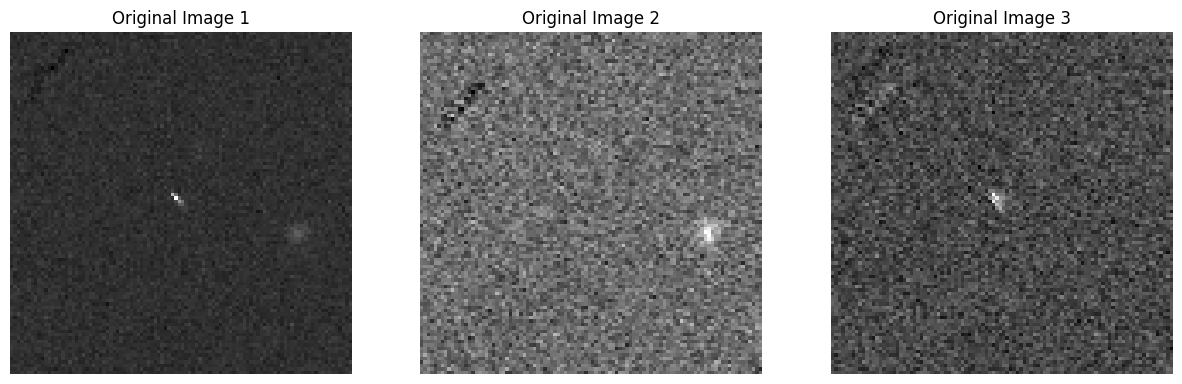

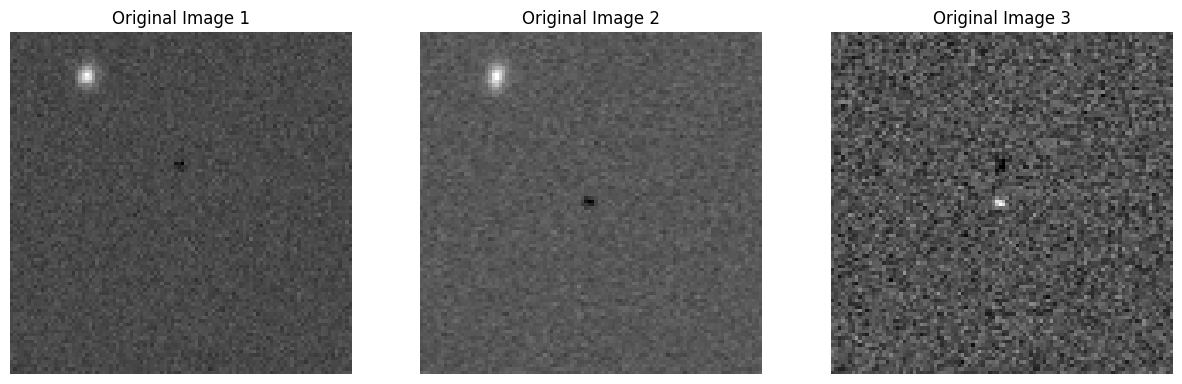

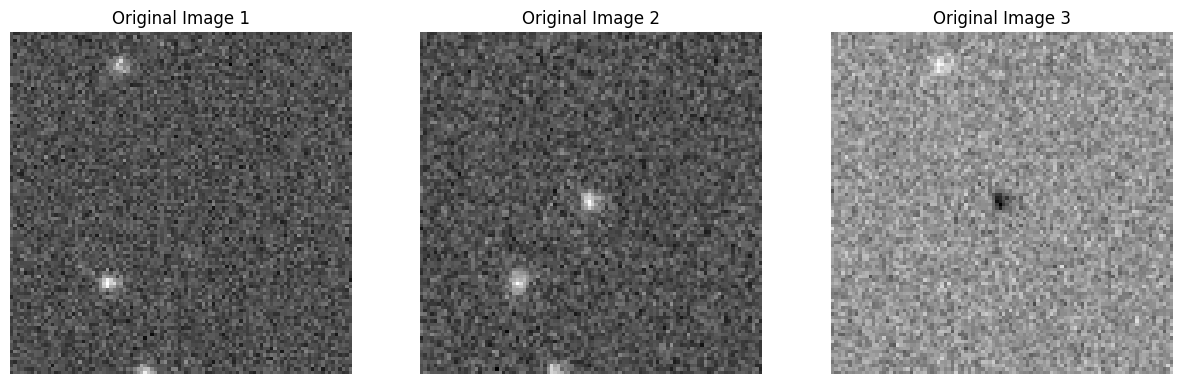

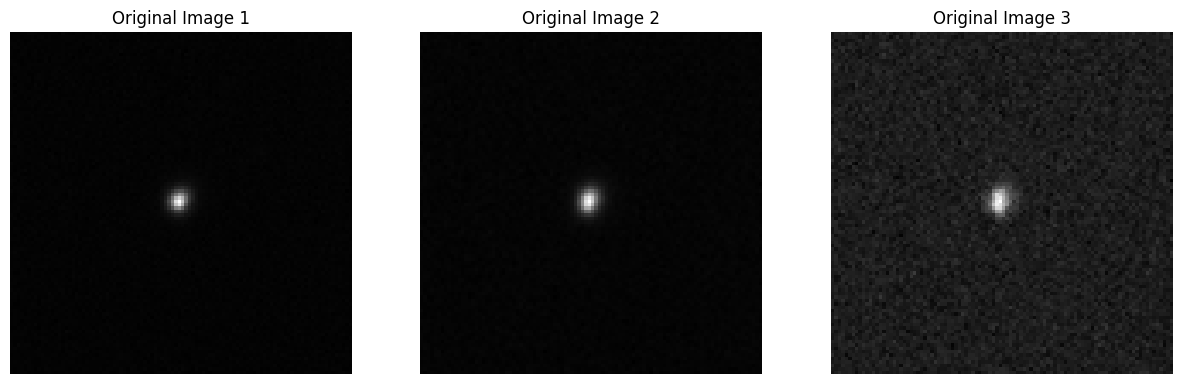

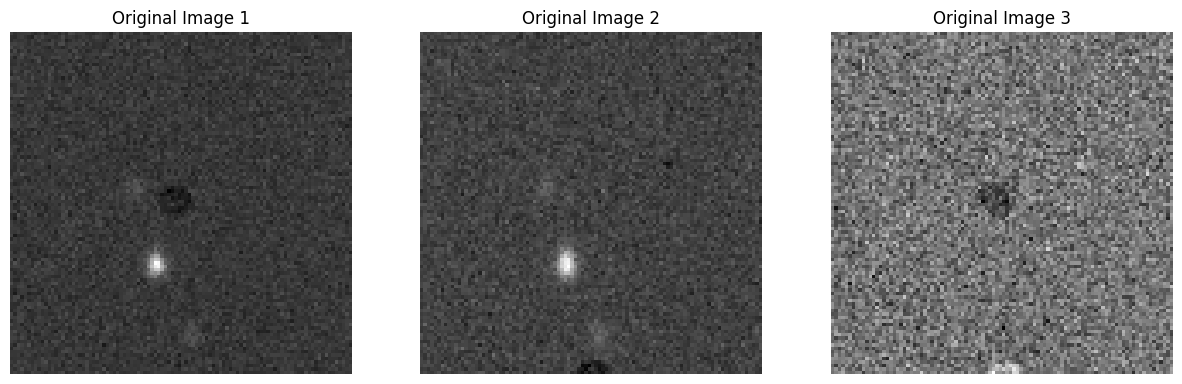

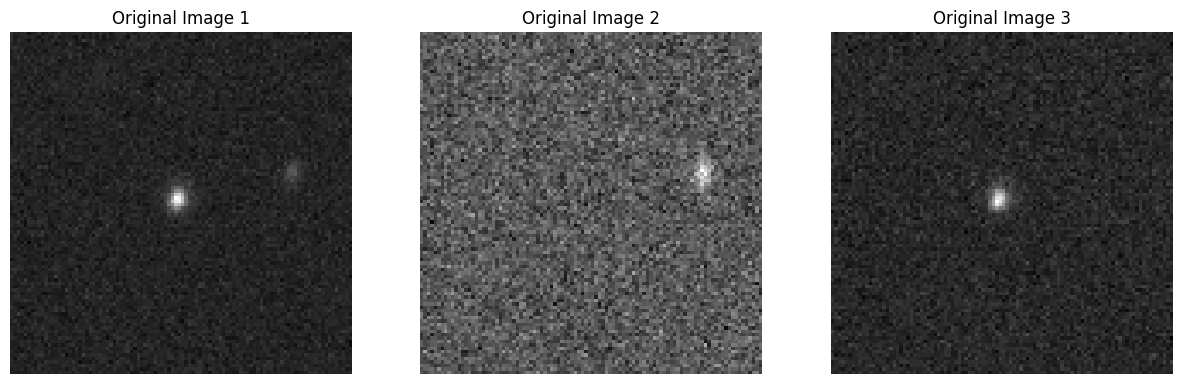

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

file_path = '/content/drive/MyDrive/Colab Notebooks/GEMINI_PROJECT/collected_ims.npy'
quadruplets = np.load(file_path)

# Load the labels
labels = np.load('/content/drive/MyDrive/Colab Notebooks/GEMINI_PROJECT/collected_vet.npy')
labels_df = pd.DataFrame(labels, columns=['label'])
labels_df['label'] = labels_df['label'].apply(lambda x: 'Real' if x > 0.5 else 'Bogus')

def plot_images(index_no, dataset, processed_images=None):
    """Plots the images, both original and optionally preprocessed, instead of saving them."""
    plt.figure(figsize=(15, 10))

    for j in range(3):
        arr = dataset[index_no, :, :, j]
        plt.subplot(2, 3, j + 1)
        plt.imshow(arr, cmap='gray')
        plt.axis('off')
        plt.title(f'Original Image {j + 1}')

    if processed_images is not None:
        titles = ['Real Image', 'Reference Image', 'Difference Image']
        for j in range(3):
            arr = processed_images[j]
            plt.subplot(2, 3, j + 4)
            plt.imshow(arr, cmap='gray')
            plt.axis('off')
            plt.title(f'Processed {titles[j]}')

    plt.show()

def preprocess(nd_array, label_array, index_no):
    """Preprocesses a pair of images from a dataset for analysis.
    This function takes a multi-dimensional array containing image data, a corresponding array of labels, and an index. It then:

    1. **Combines** the real and reference images at the specified index.
    2. **Normalizes** the combined image to a range of 0-255.
    3. **Separates** the normalized image back into real and reference images.
    4. **Rescales** the available difference image.
    5. **Returns** the real image, reference image, rescaled difference image, and the label associated with the index.

    Args:
        nd_array: A multi-dimensional array containing image data. Each element is expected to be a 4-dimensional array representing a pair of images (real and reference).
        label_array: A 1-dimensional array containing labels corresponding to the images in `nd_array`.
        index_no: The index of the image pair to be processed.

    Returns:
        A tuple containing:
        - real_image: A 2D array representing the real image.
        - ref_image: A 2D array representing the reference image.
        - diff_image: A 2D array representing the rescaled difference image.
        - label: The label associated with the processed image pair.
    """
    # Combine the real image and the reference image
    comb_im = np.append(nd_array[index_no, 0:100, 0:100, 0], nd_array[index_no, 0:100, 0:100, 1])
    # Normalize the combined image with clipping to 2% and 98%
    p2 = np.percentile(comb_im, 2)
    p98 = np.percentile(comb_im, 98)
    comb_im[comb_im < p2] = p2
    comb_im[comb_im > p98] = p98
    norm_comb_im = 255 * (comb_im - p2) / (p98 - p2)

    # Separate the array back
    real_image = np.reshape(norm_comb_im[0:100*100], (100, 100))
    ref_image = np.reshape(norm_comb_im[100*100:], (100, 100))

    # Rescale the already available difference image
    diff_image = np.copy(nd_array[index_no, :, :, 2])  # Create a copy to avoid modifying the original data
    p2_diff = np.percentile(diff_image, 2)
    p98_diff = np.percentile(diff_image, 98)
    diff_image[diff_image < p2_diff] = p2_diff
    diff_image[diff_image > p98_diff] = p98_diff
    norm_diff_image = 255 * (diff_image - p2_diff) / (p98_diff - p2_diff)

    # Return the real image, the reference image and the normalized difference image and the label
    return real_image, ref_image, norm_diff_image, label_array[index_no]


# Sample indexes you want to access
sample_indexes = [1, 2, 16, 18, 23, 29]

for i in sample_indexes:
    real_image, ref_image, norm_diff_image, label = preprocess(quadruplets, labels_df['label'].values, i)
    processed_images = [real_image, ref_image, norm_diff_image]
    plot_images(i, quadruplets)#, processed_images)


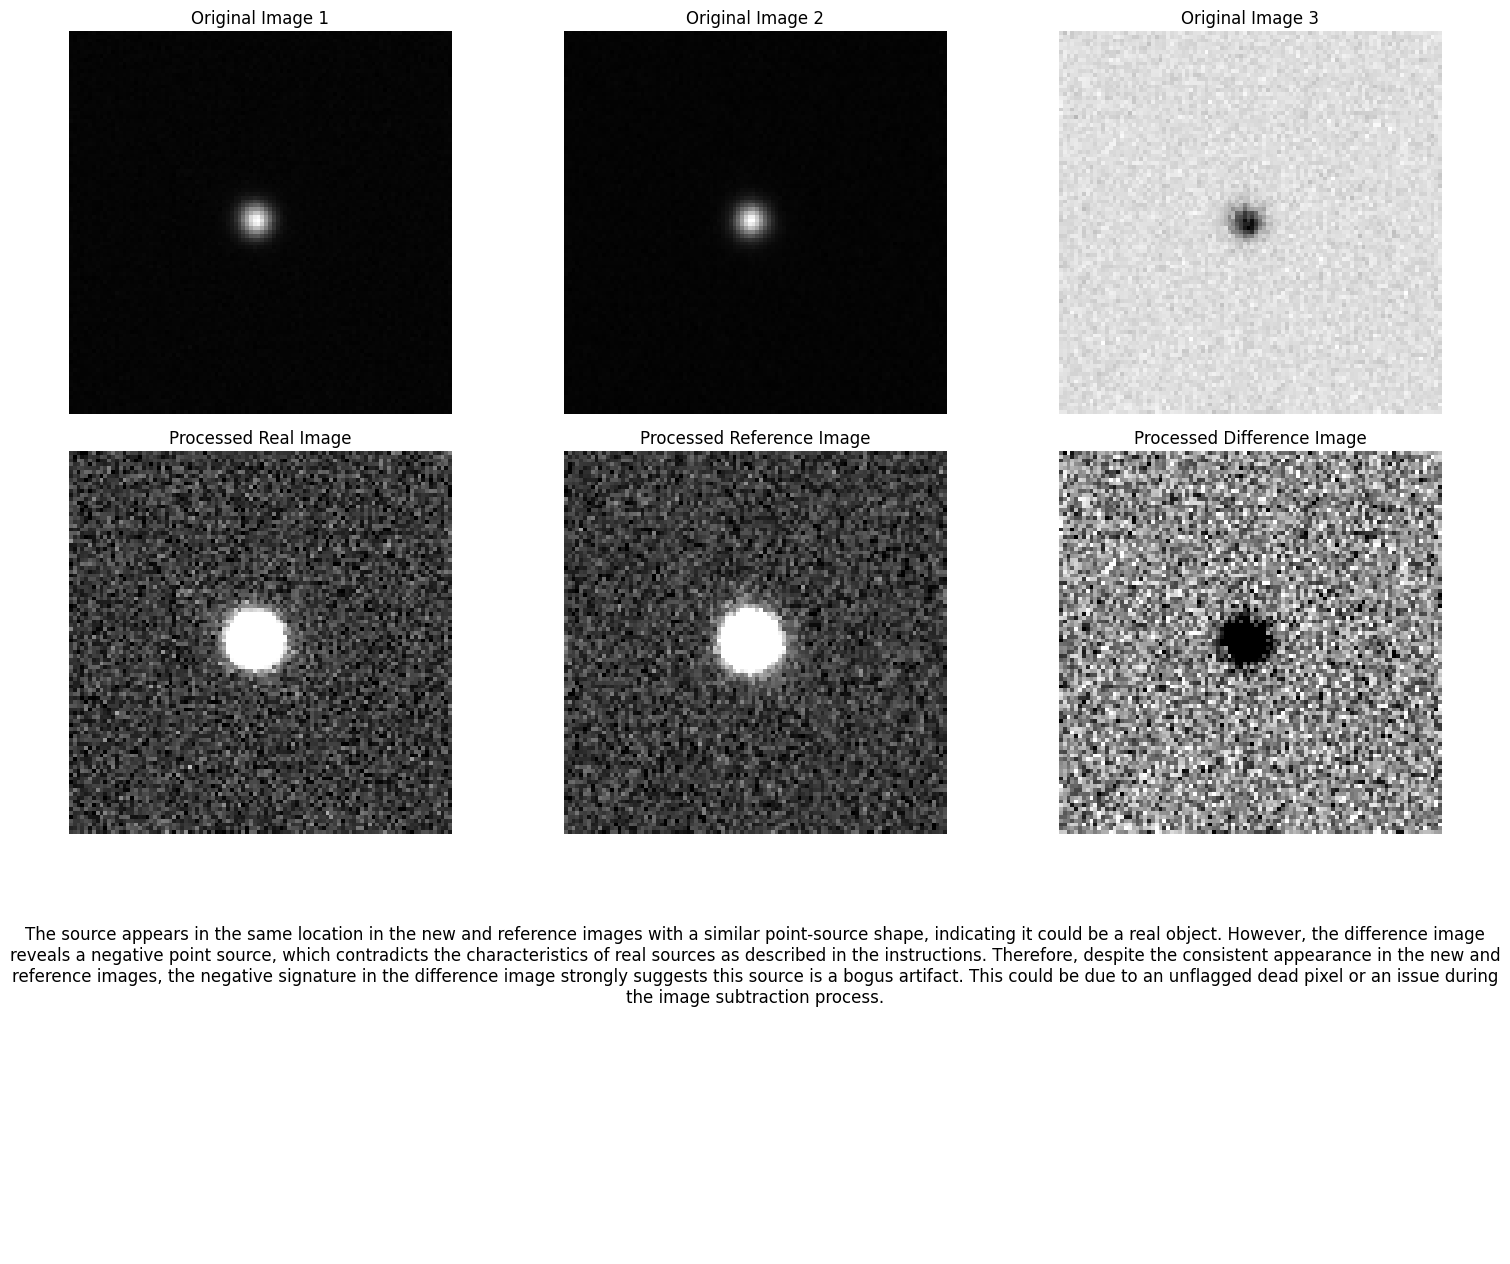

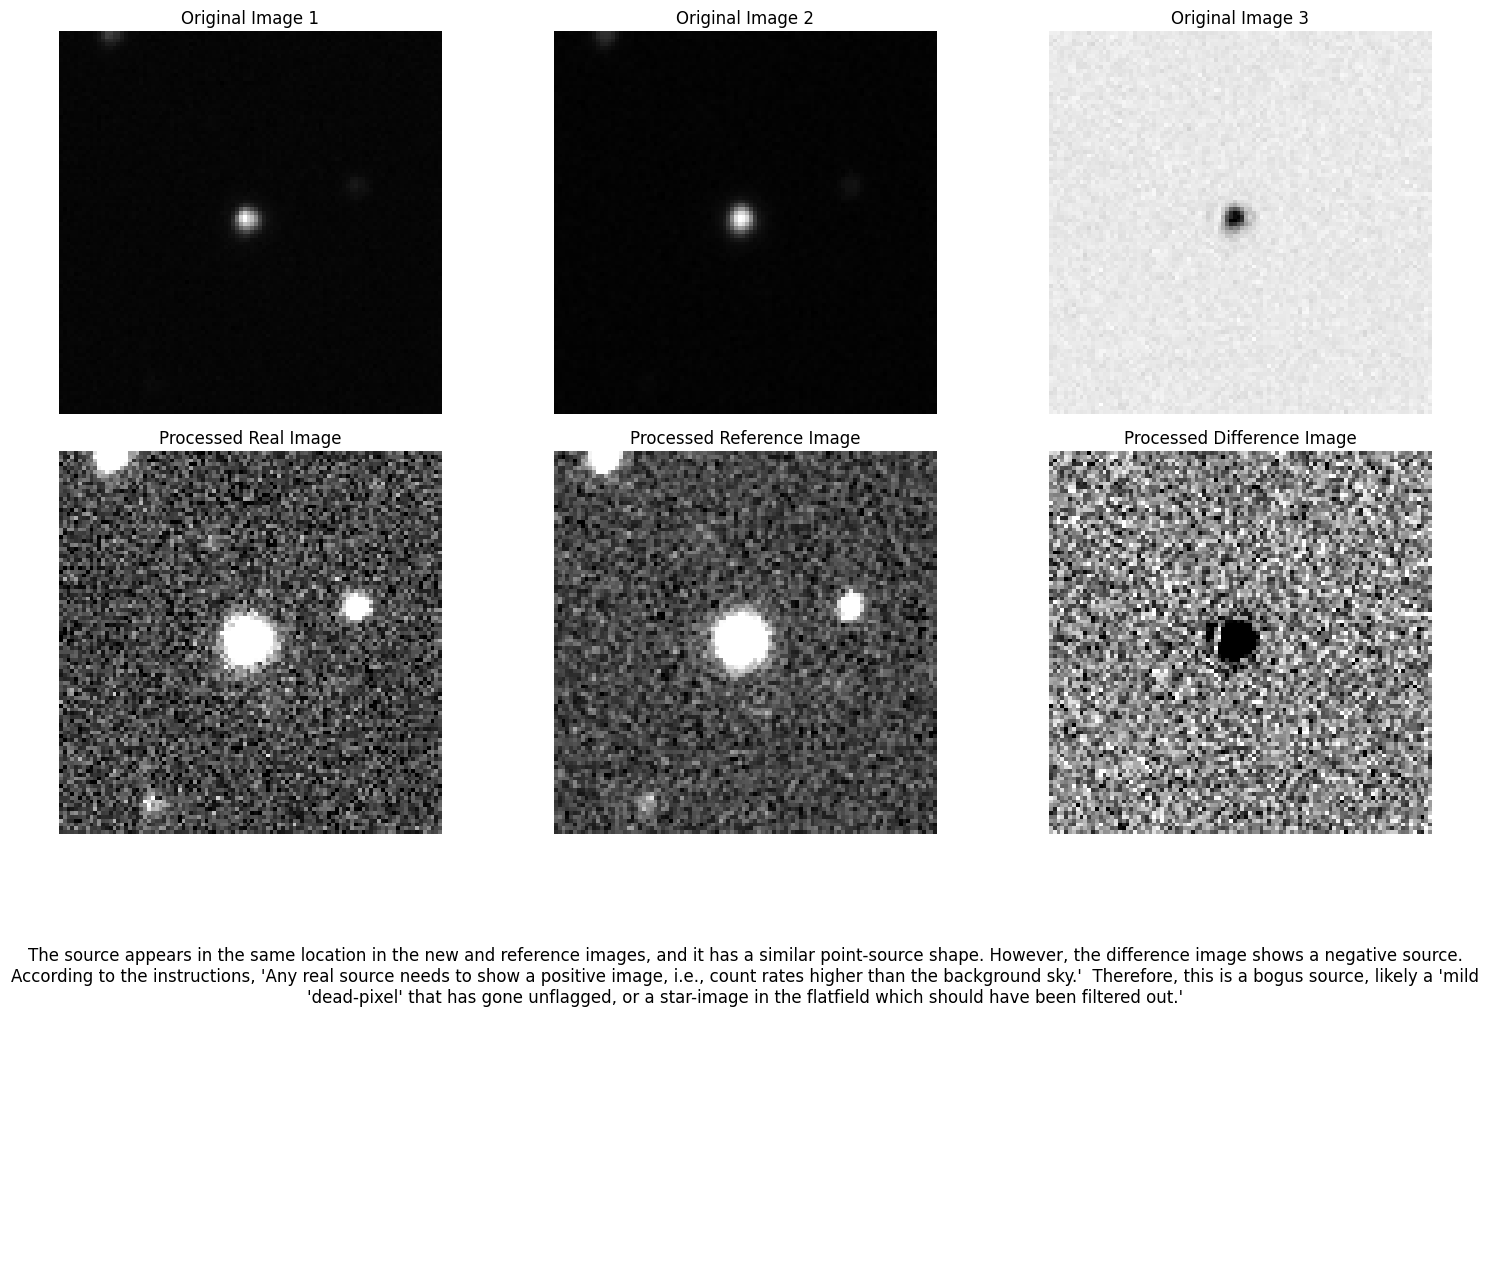

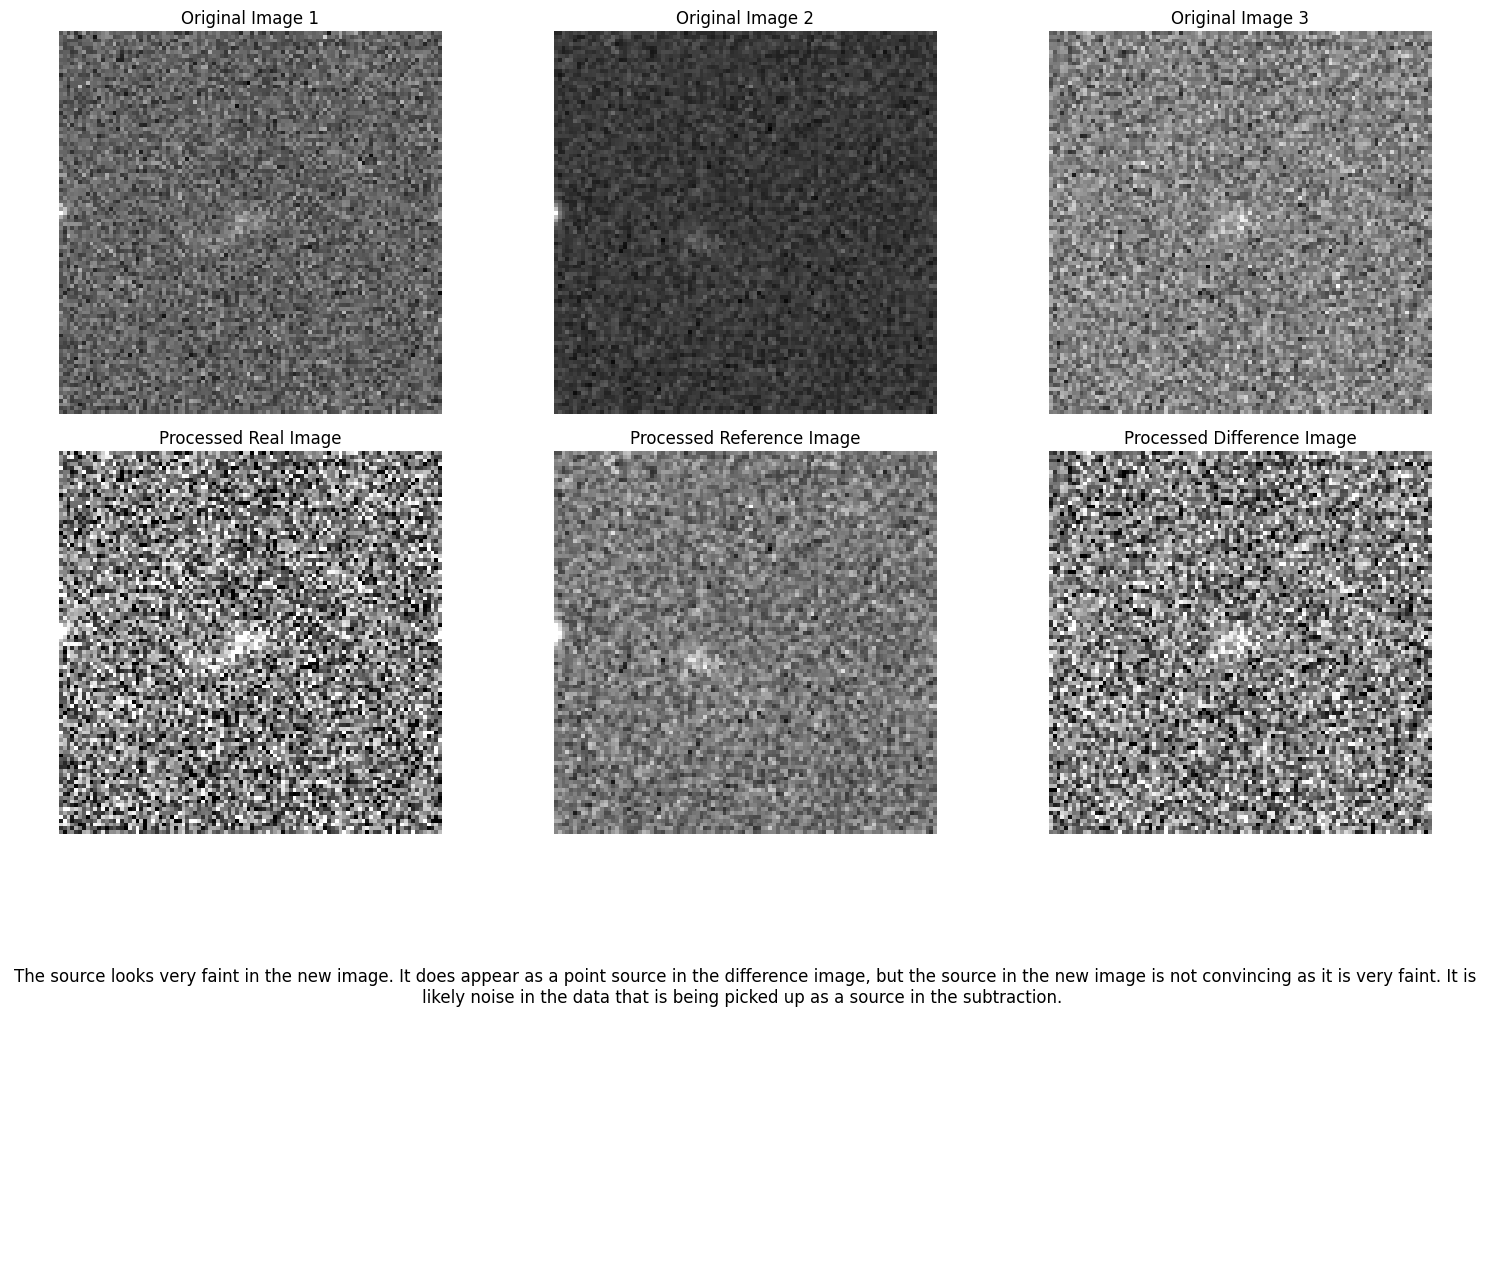

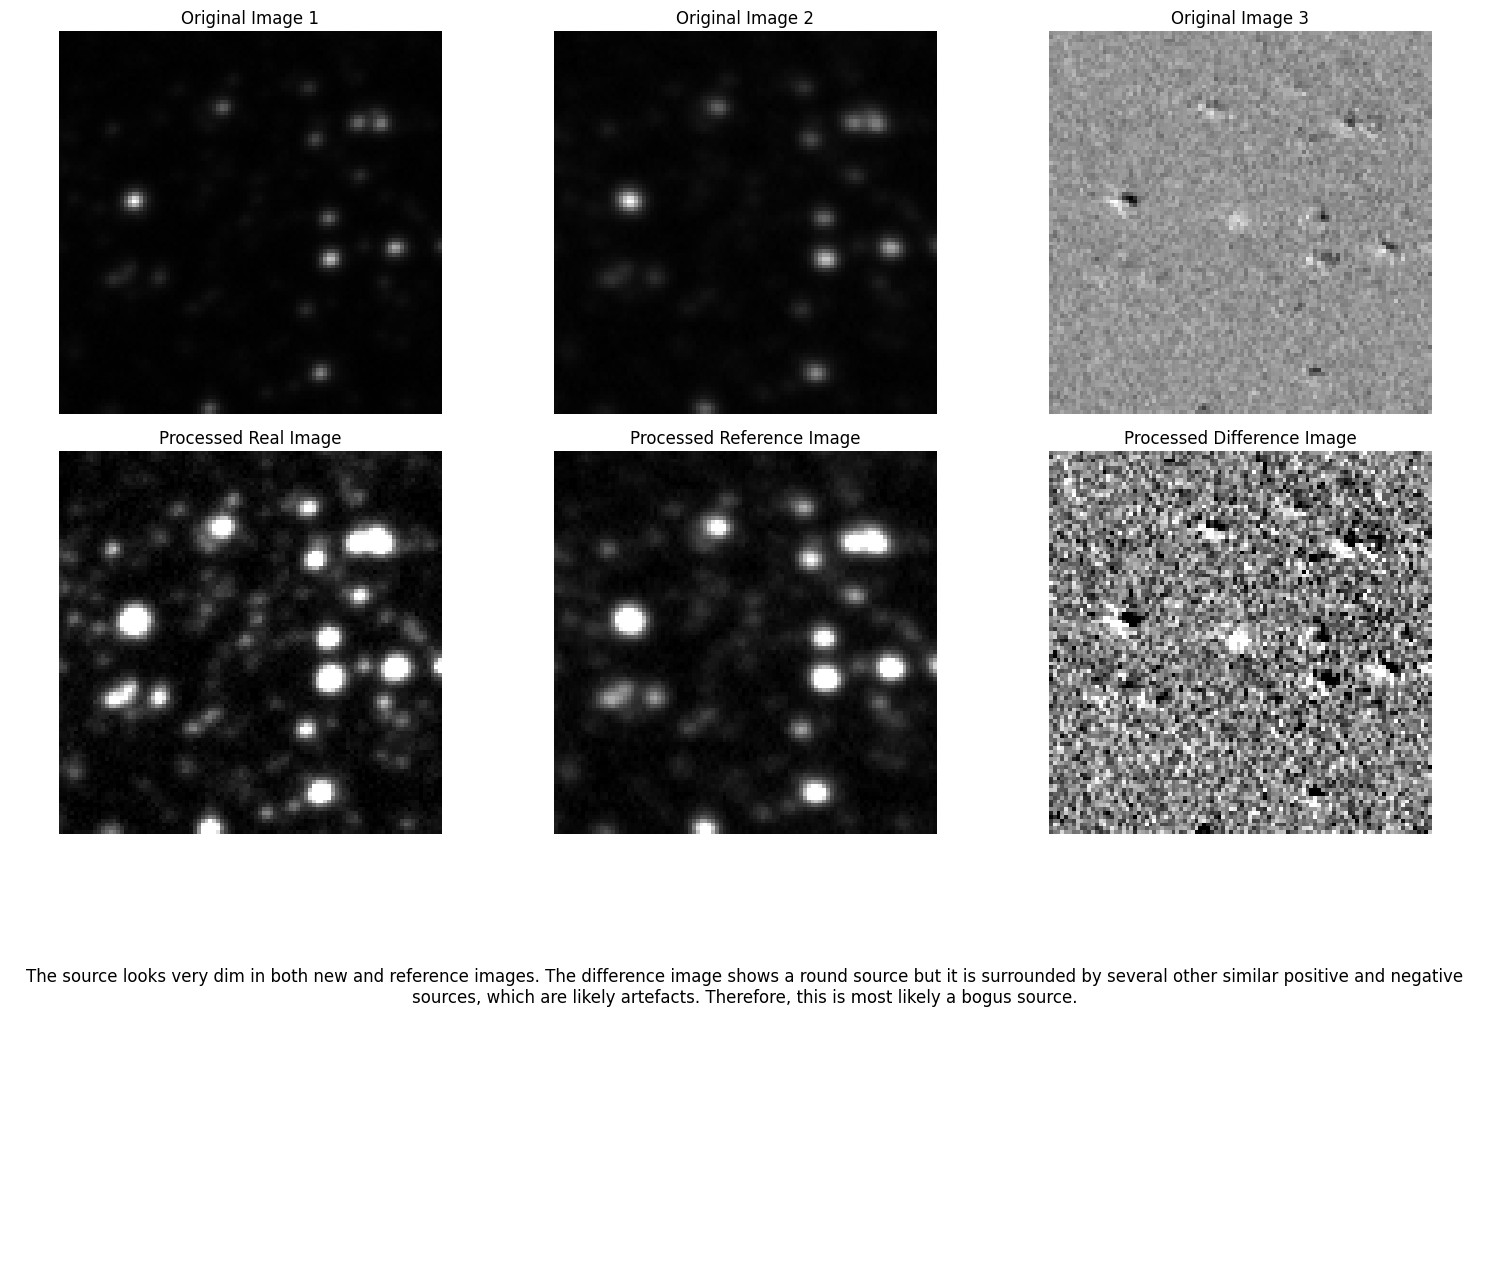

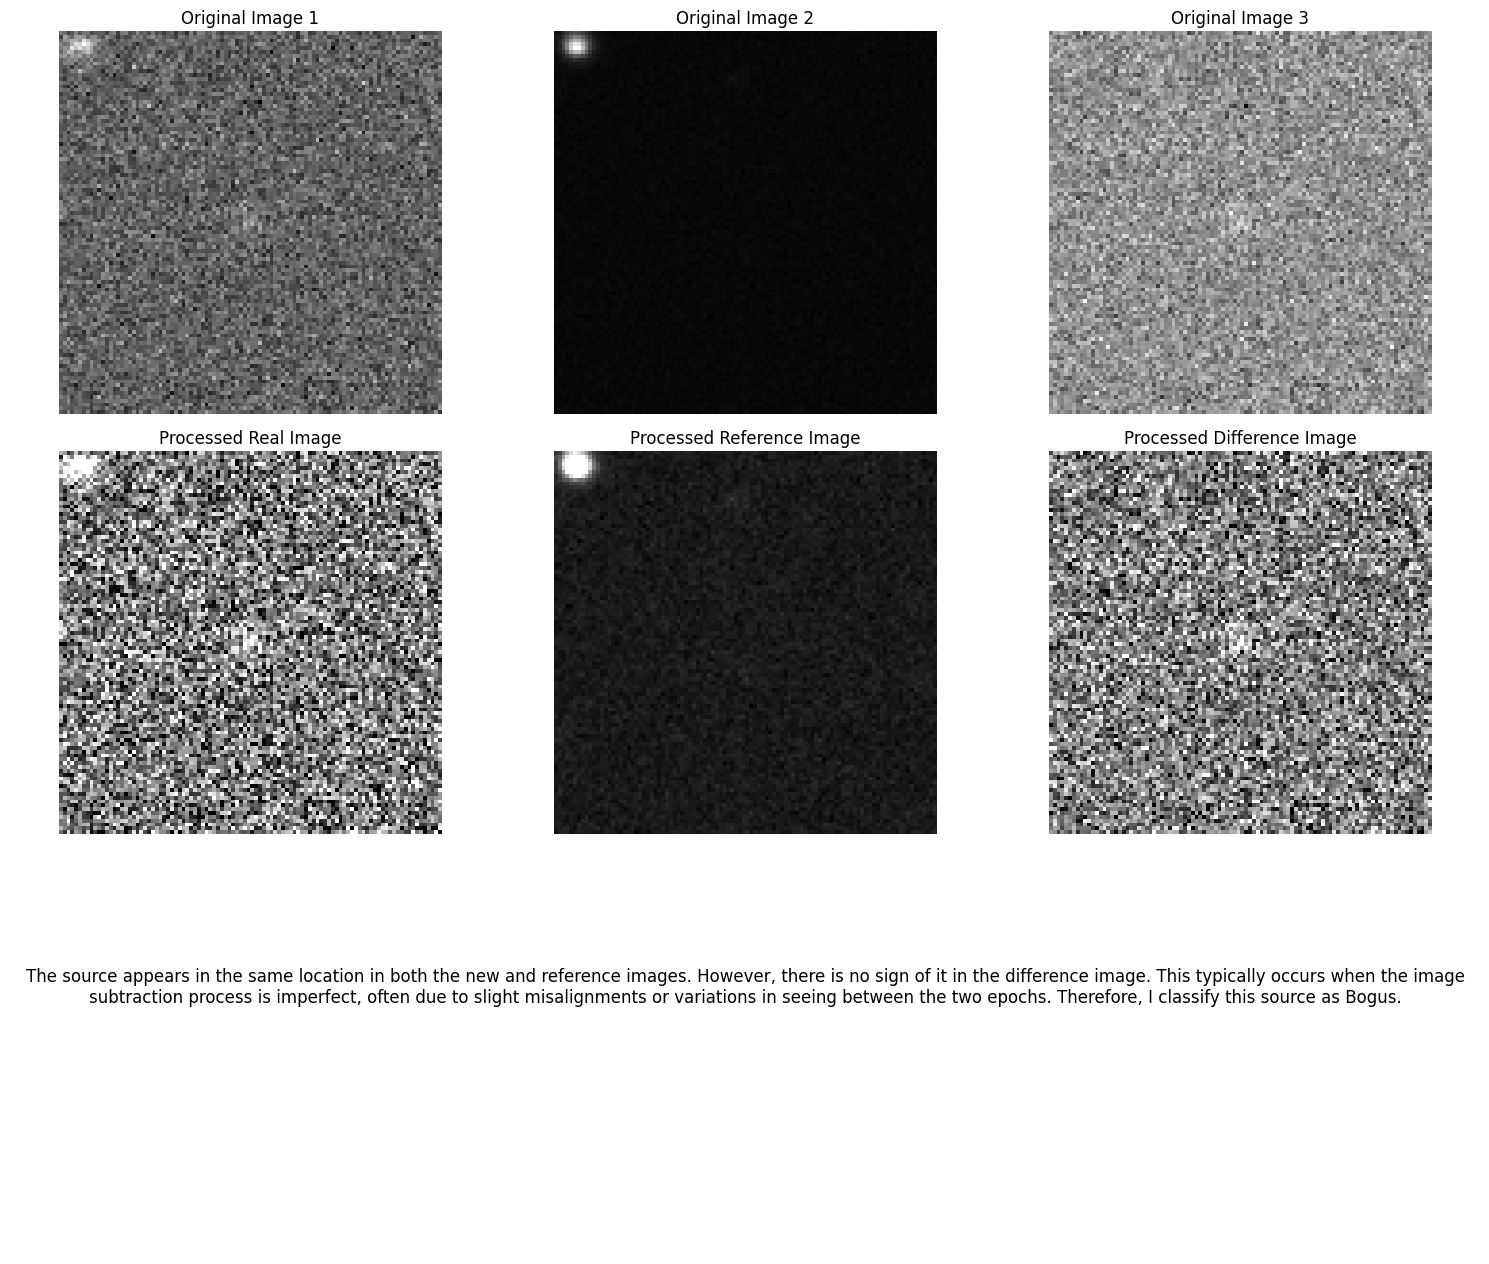

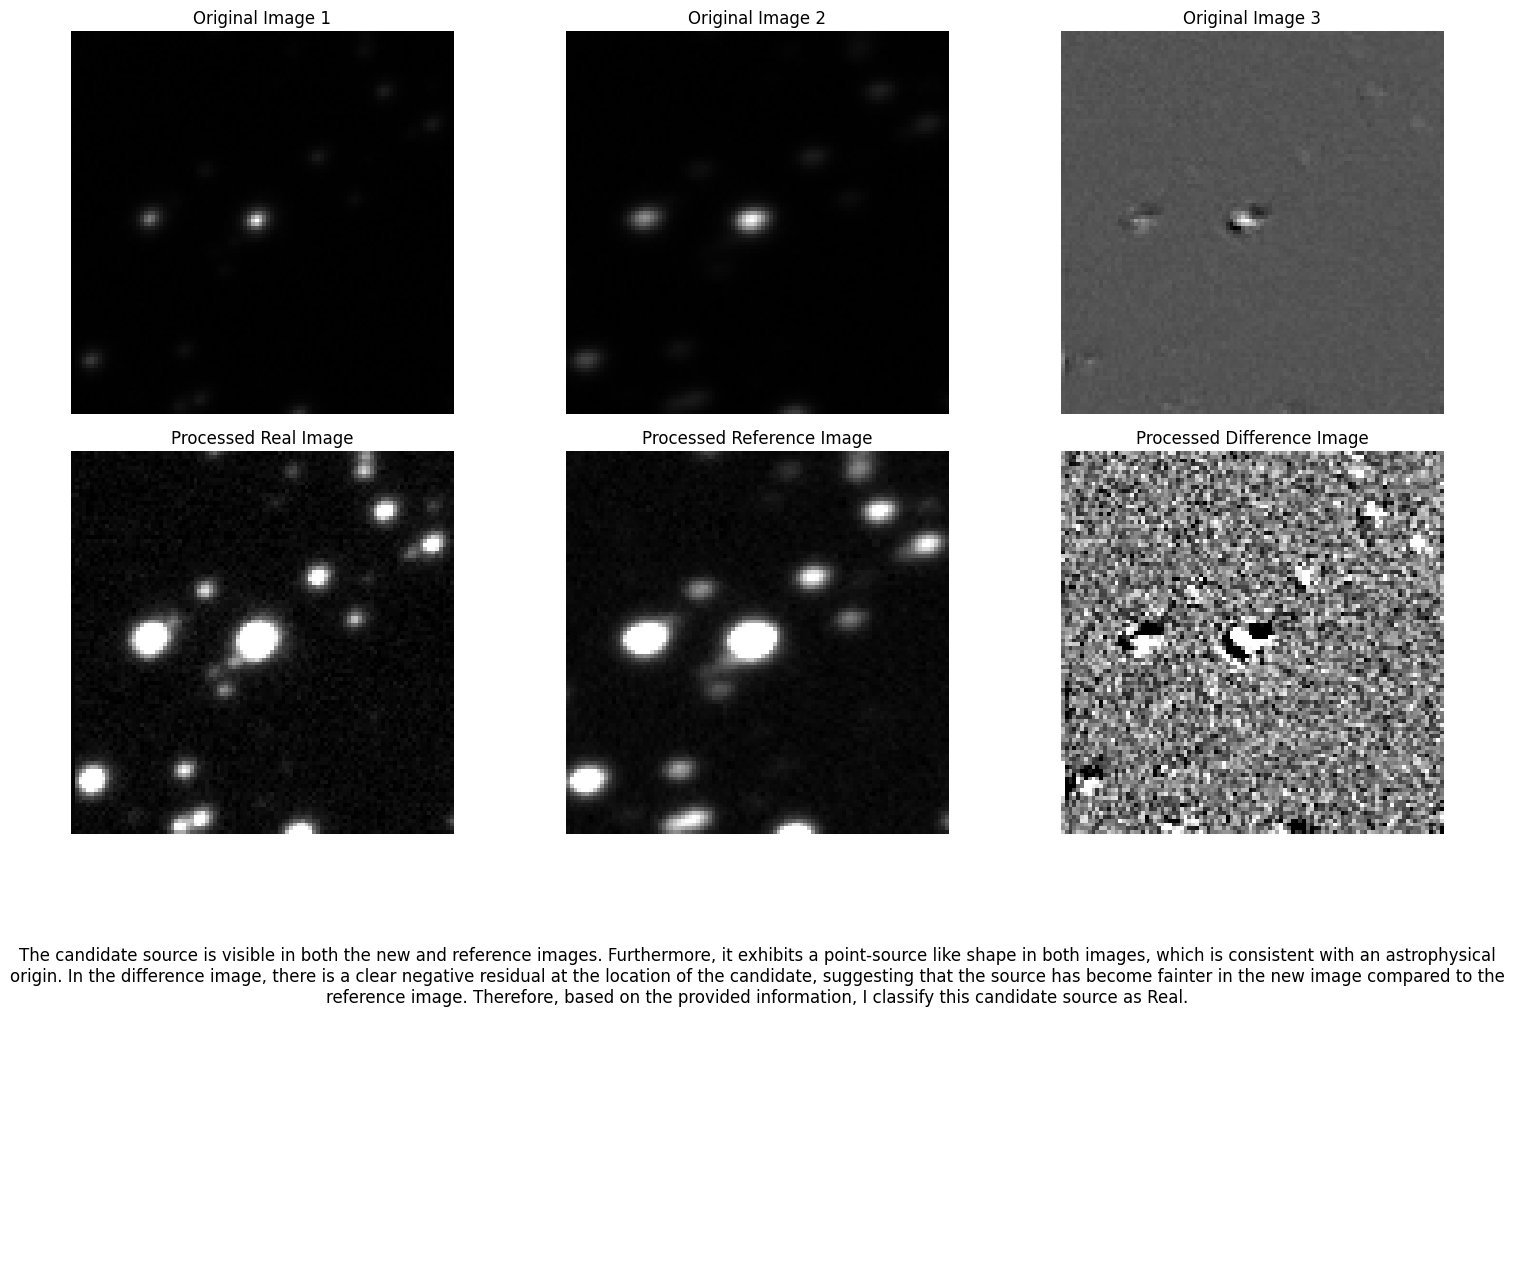

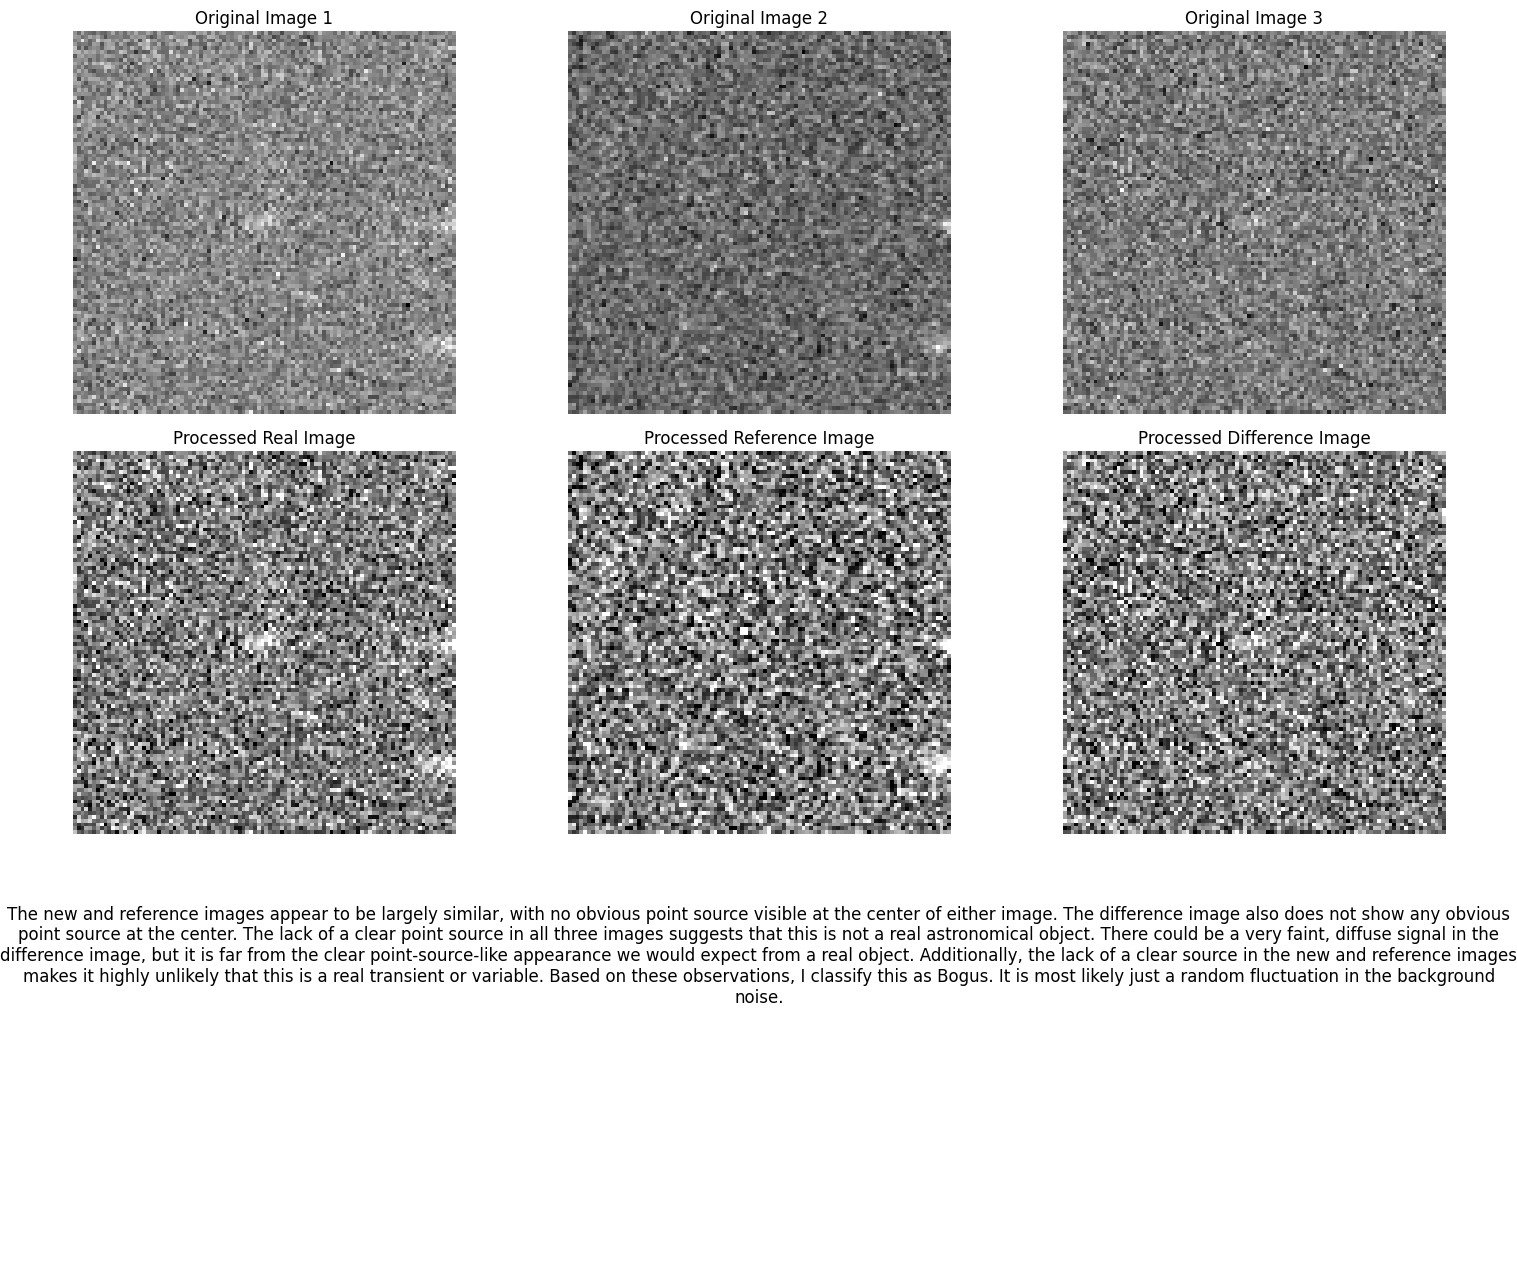

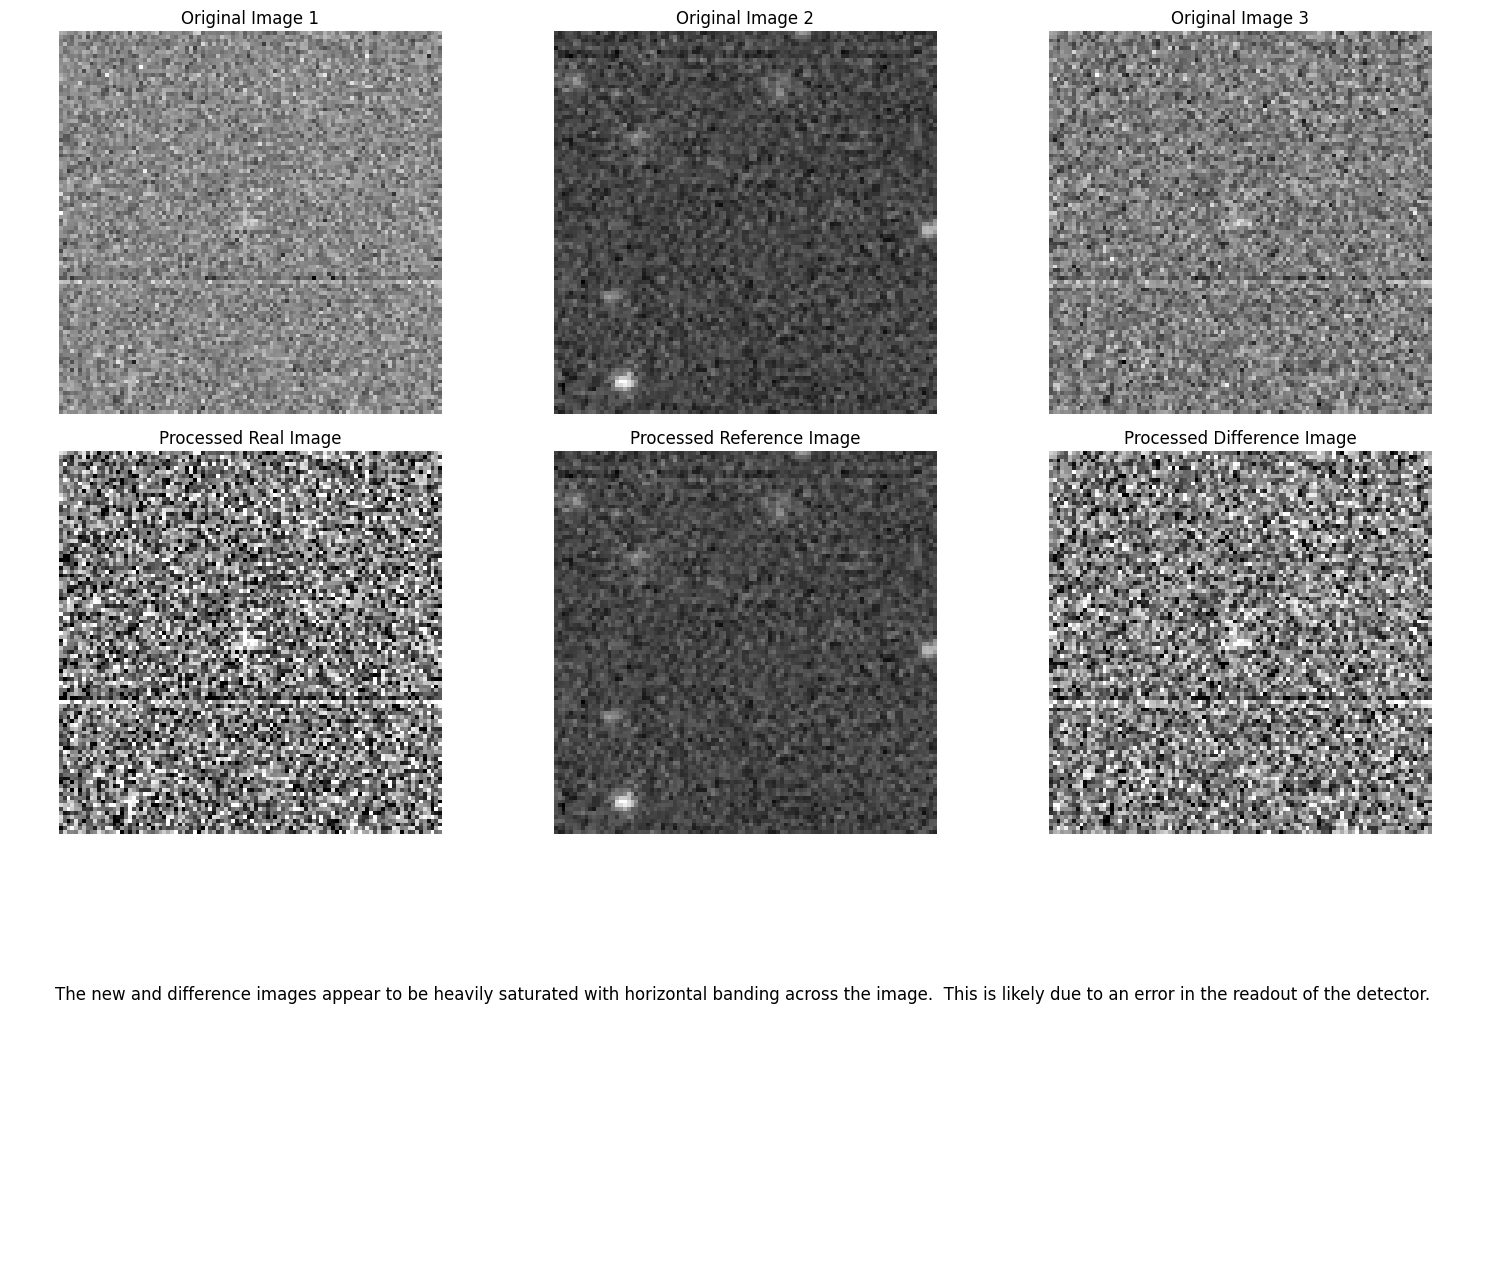

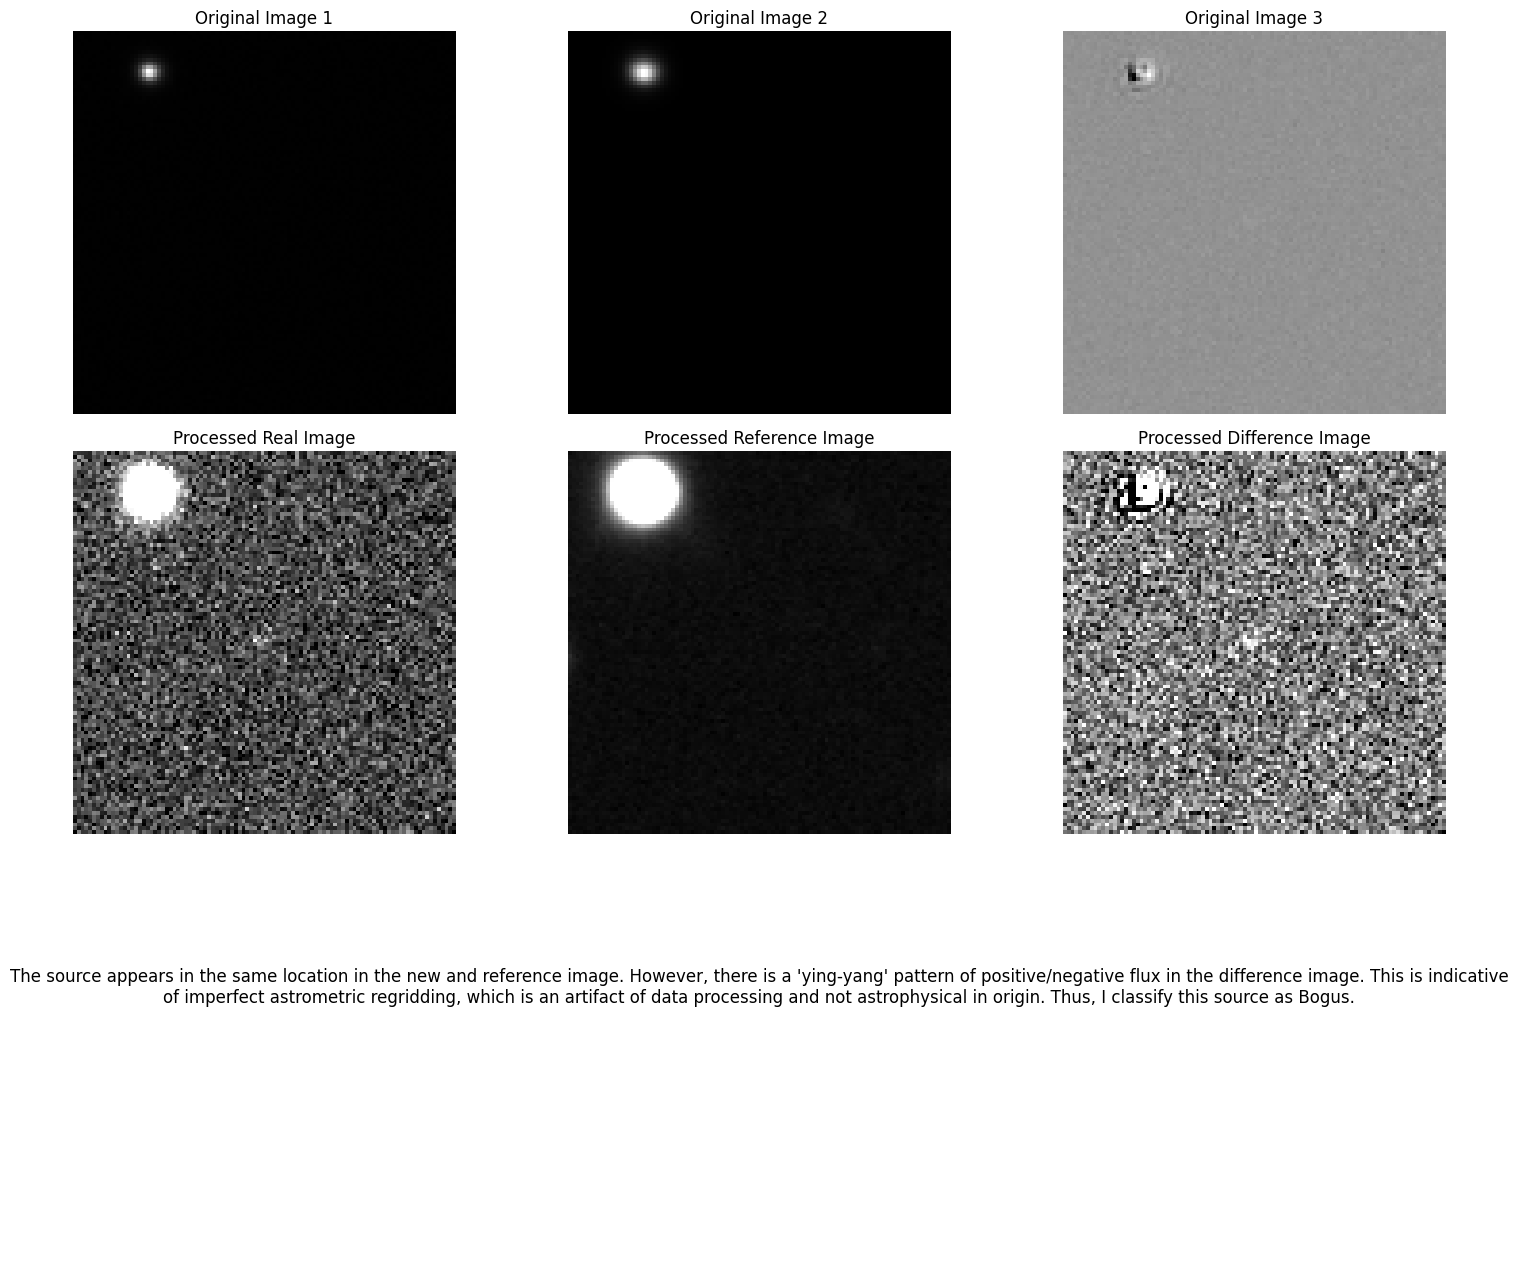

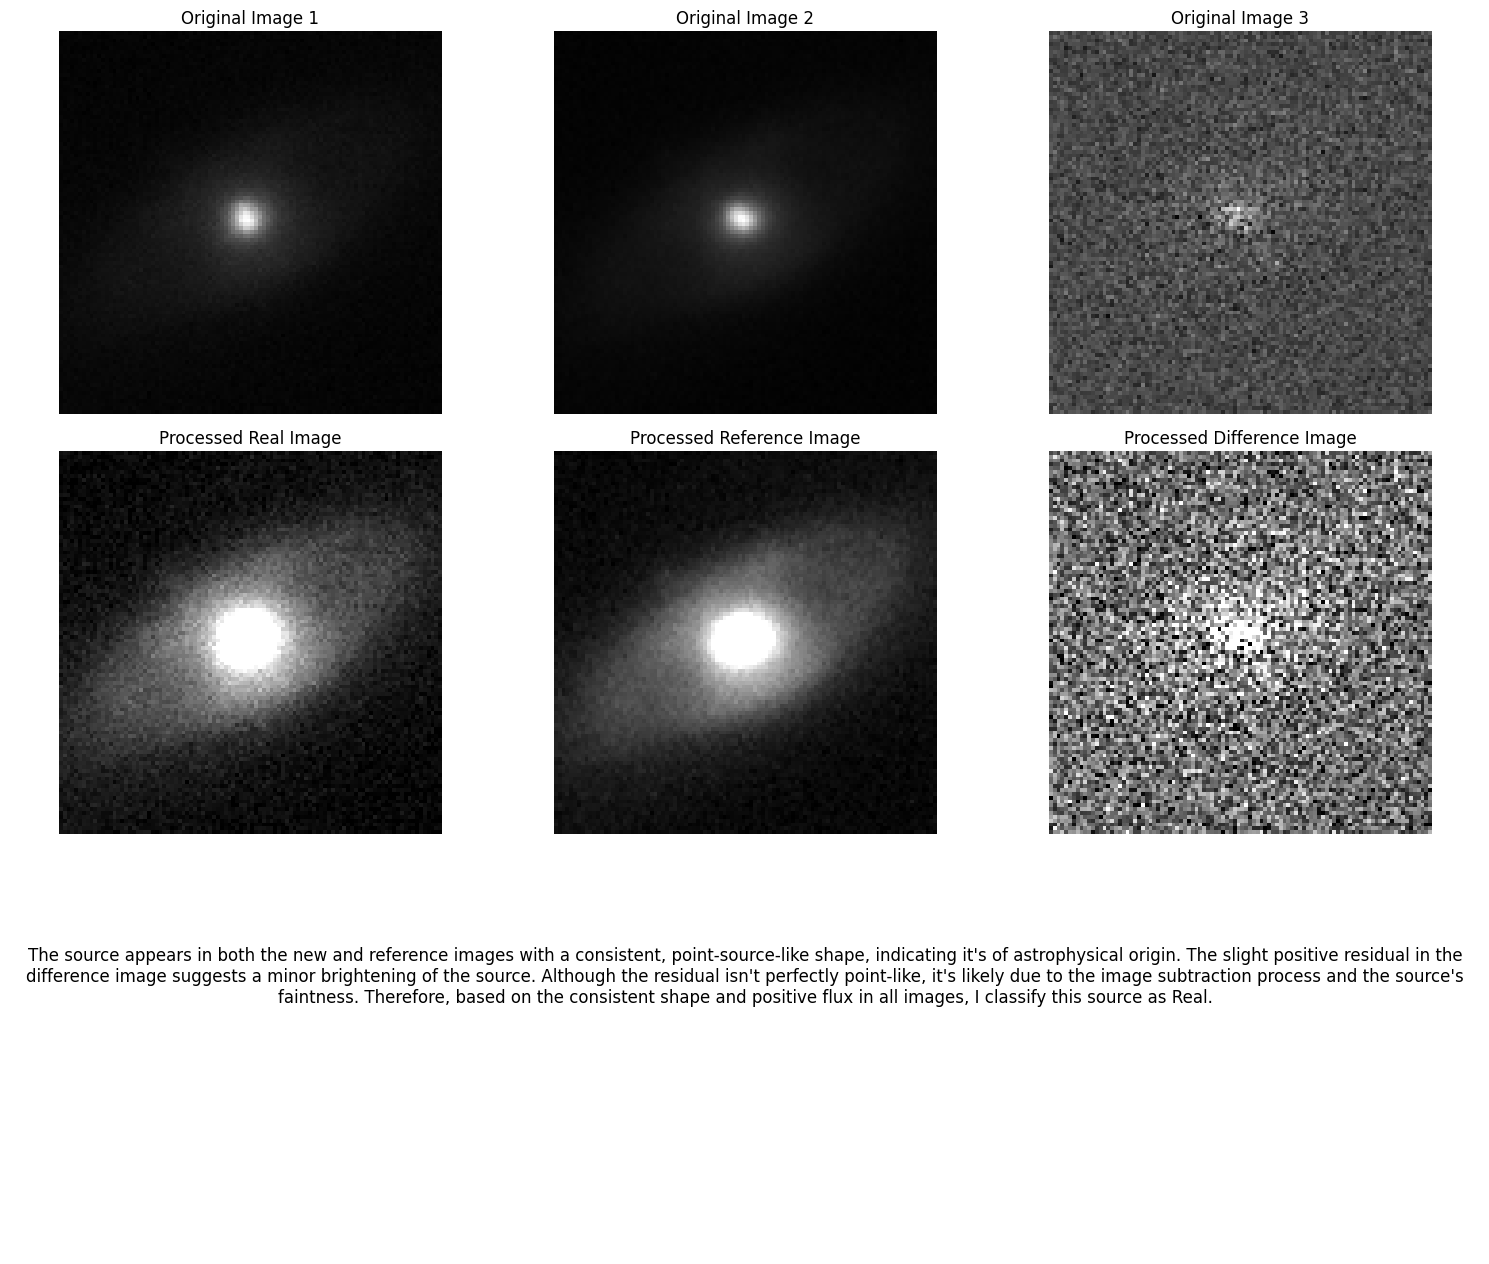

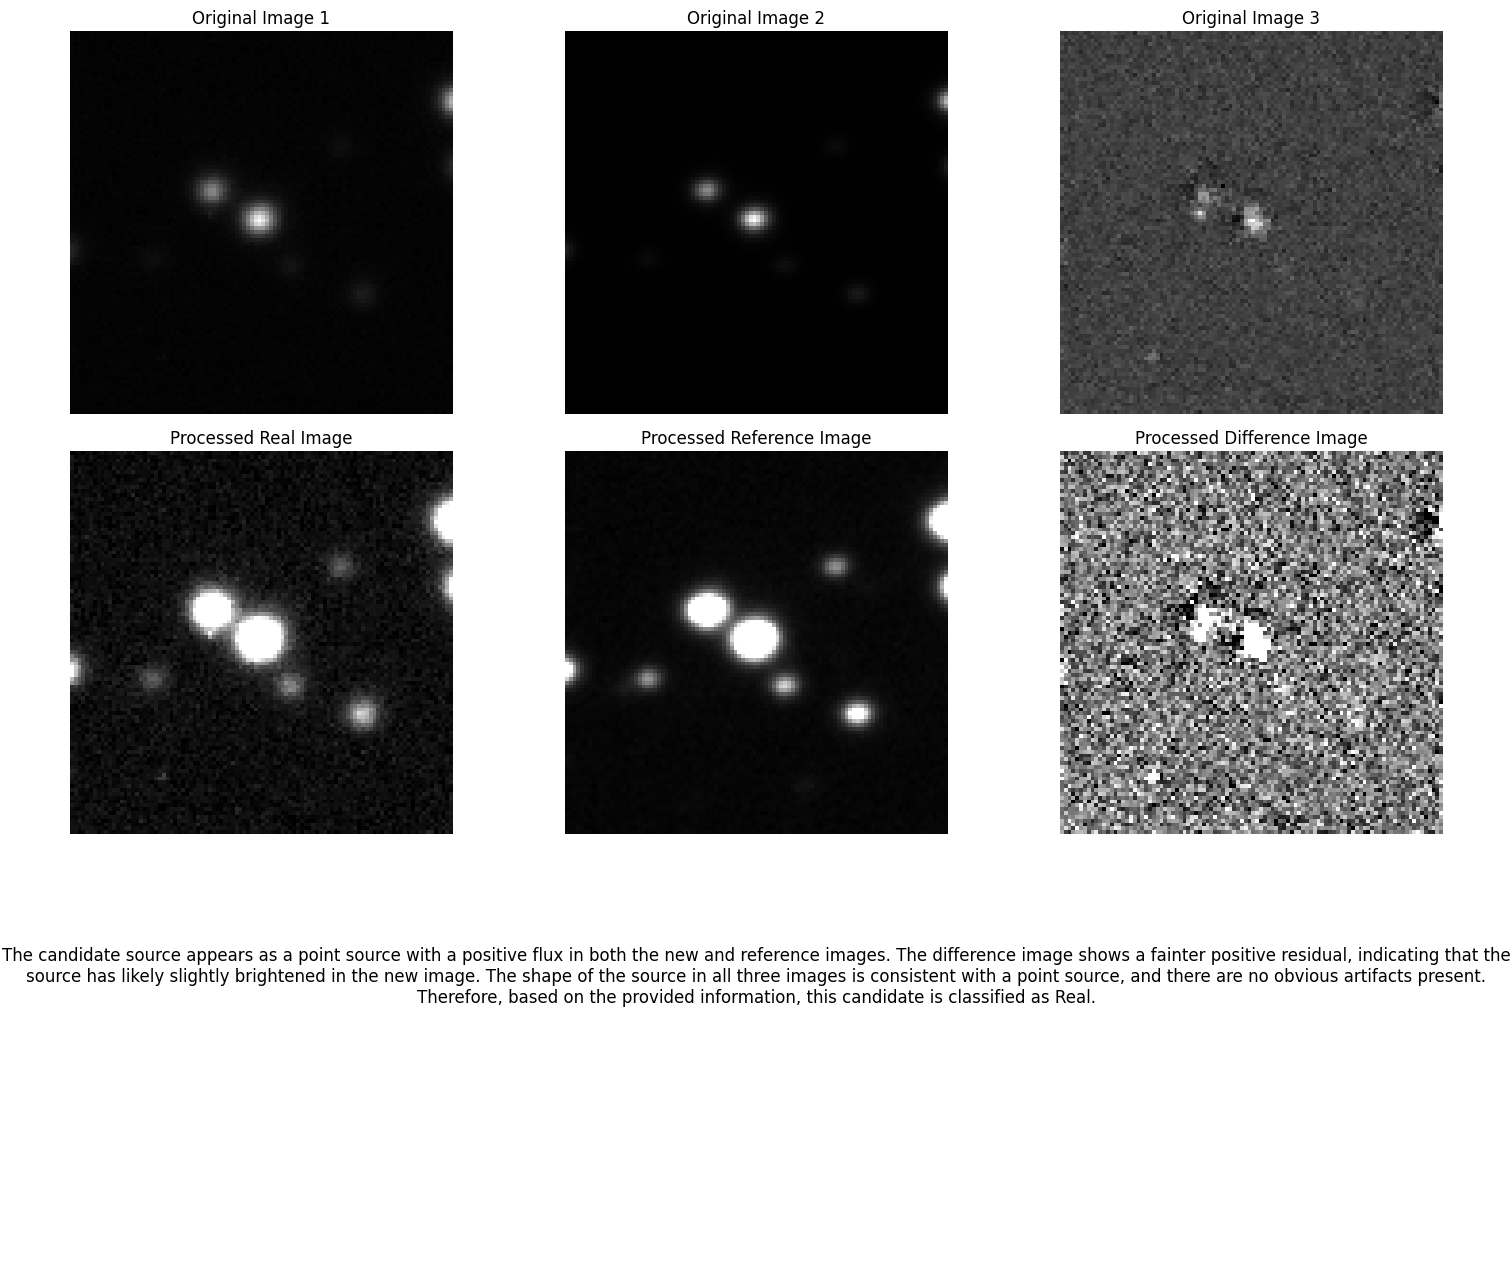

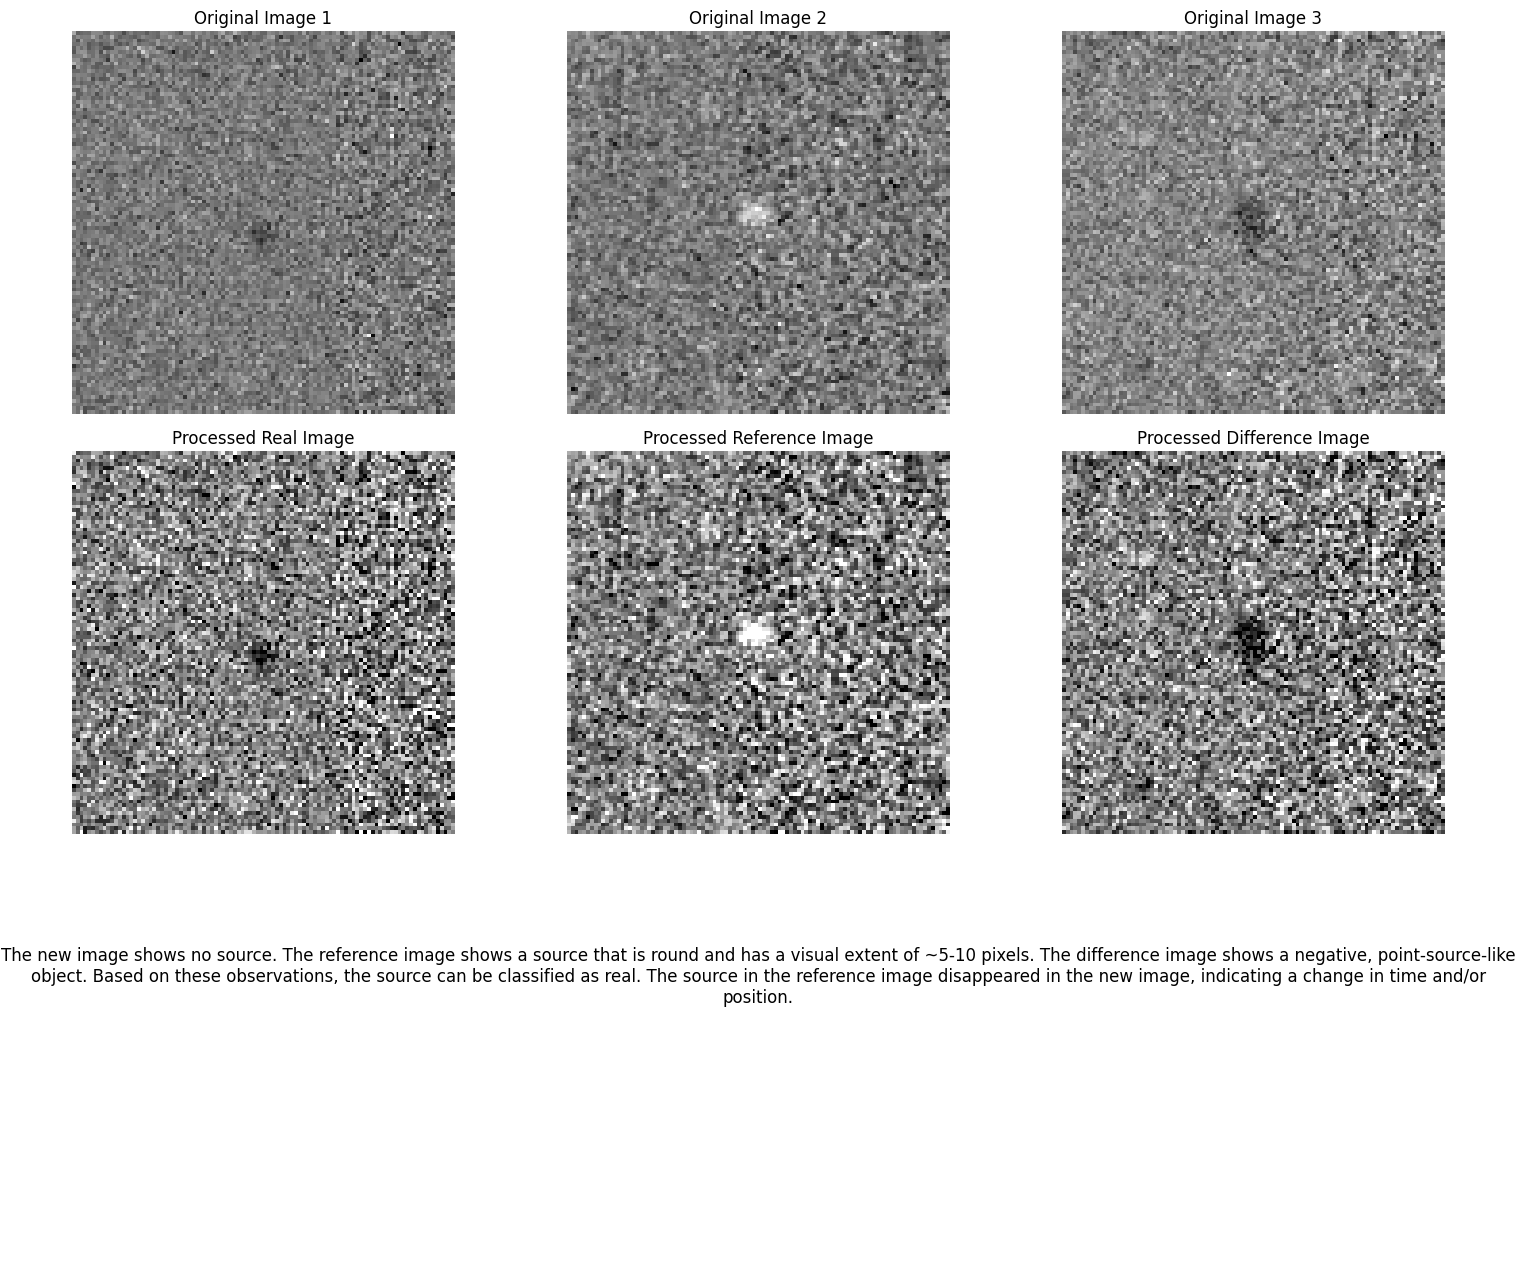

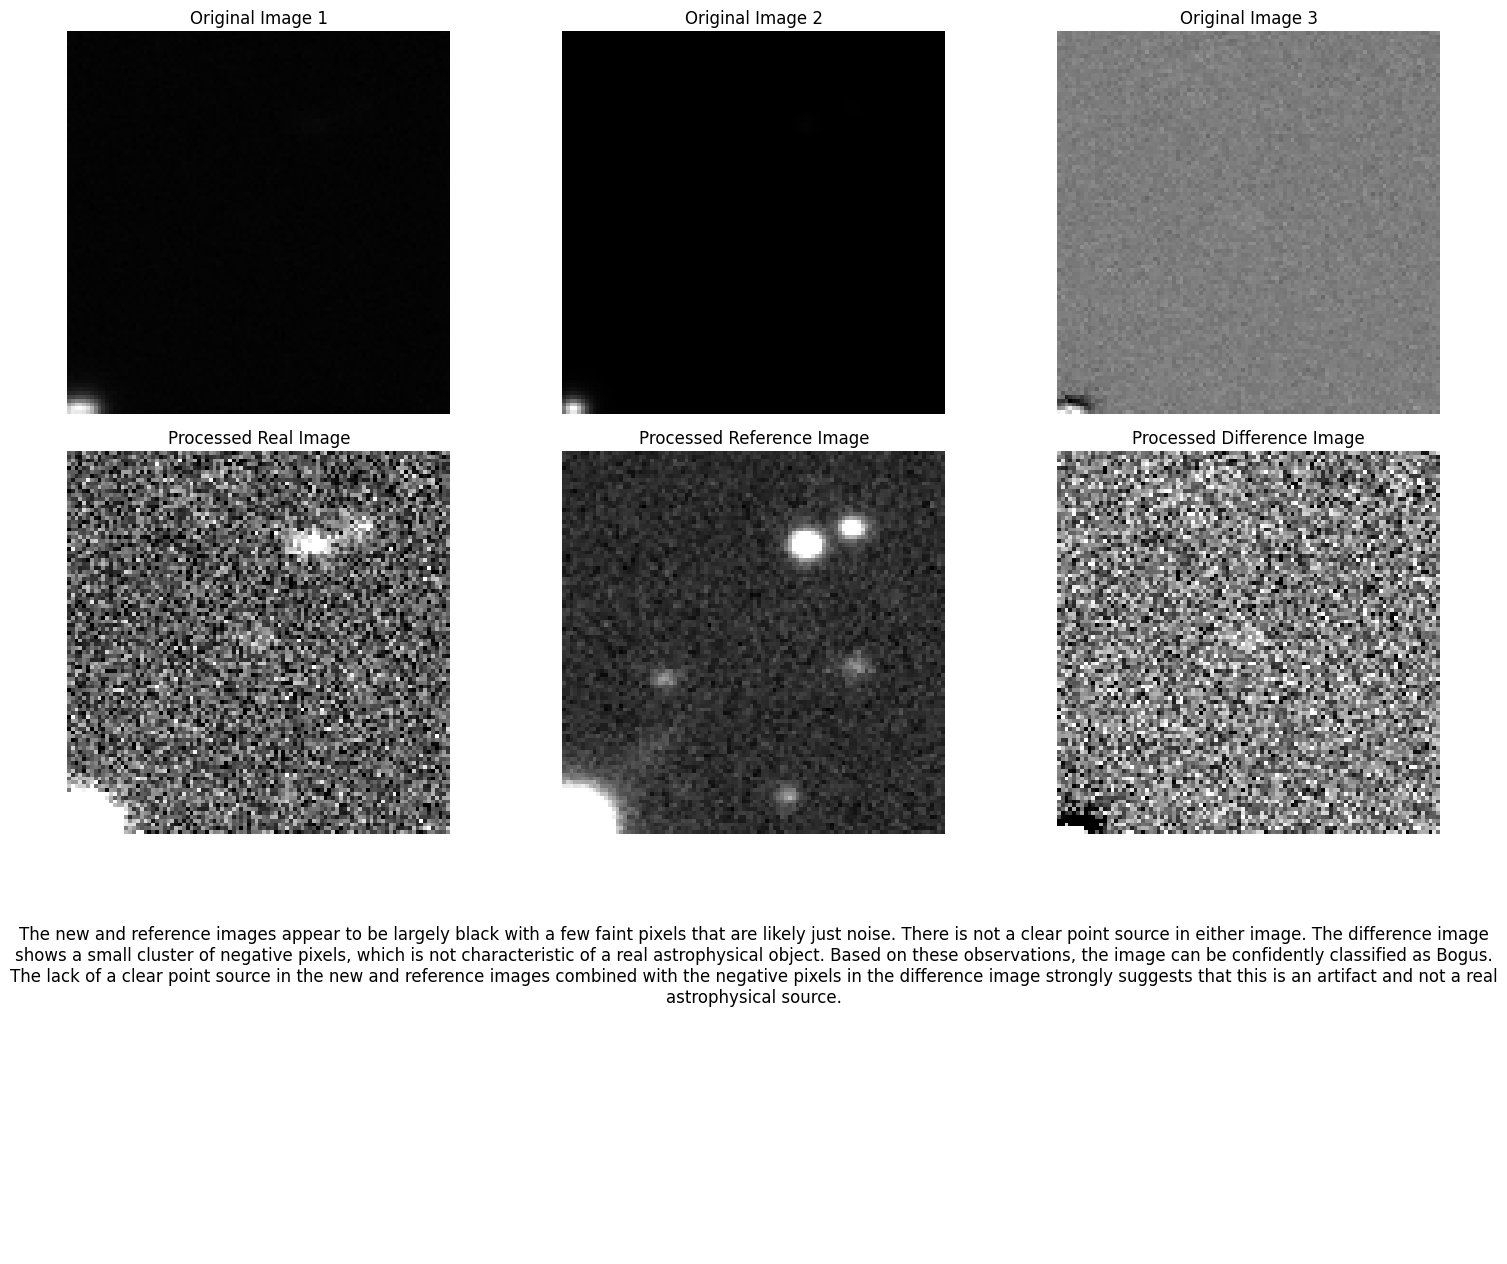

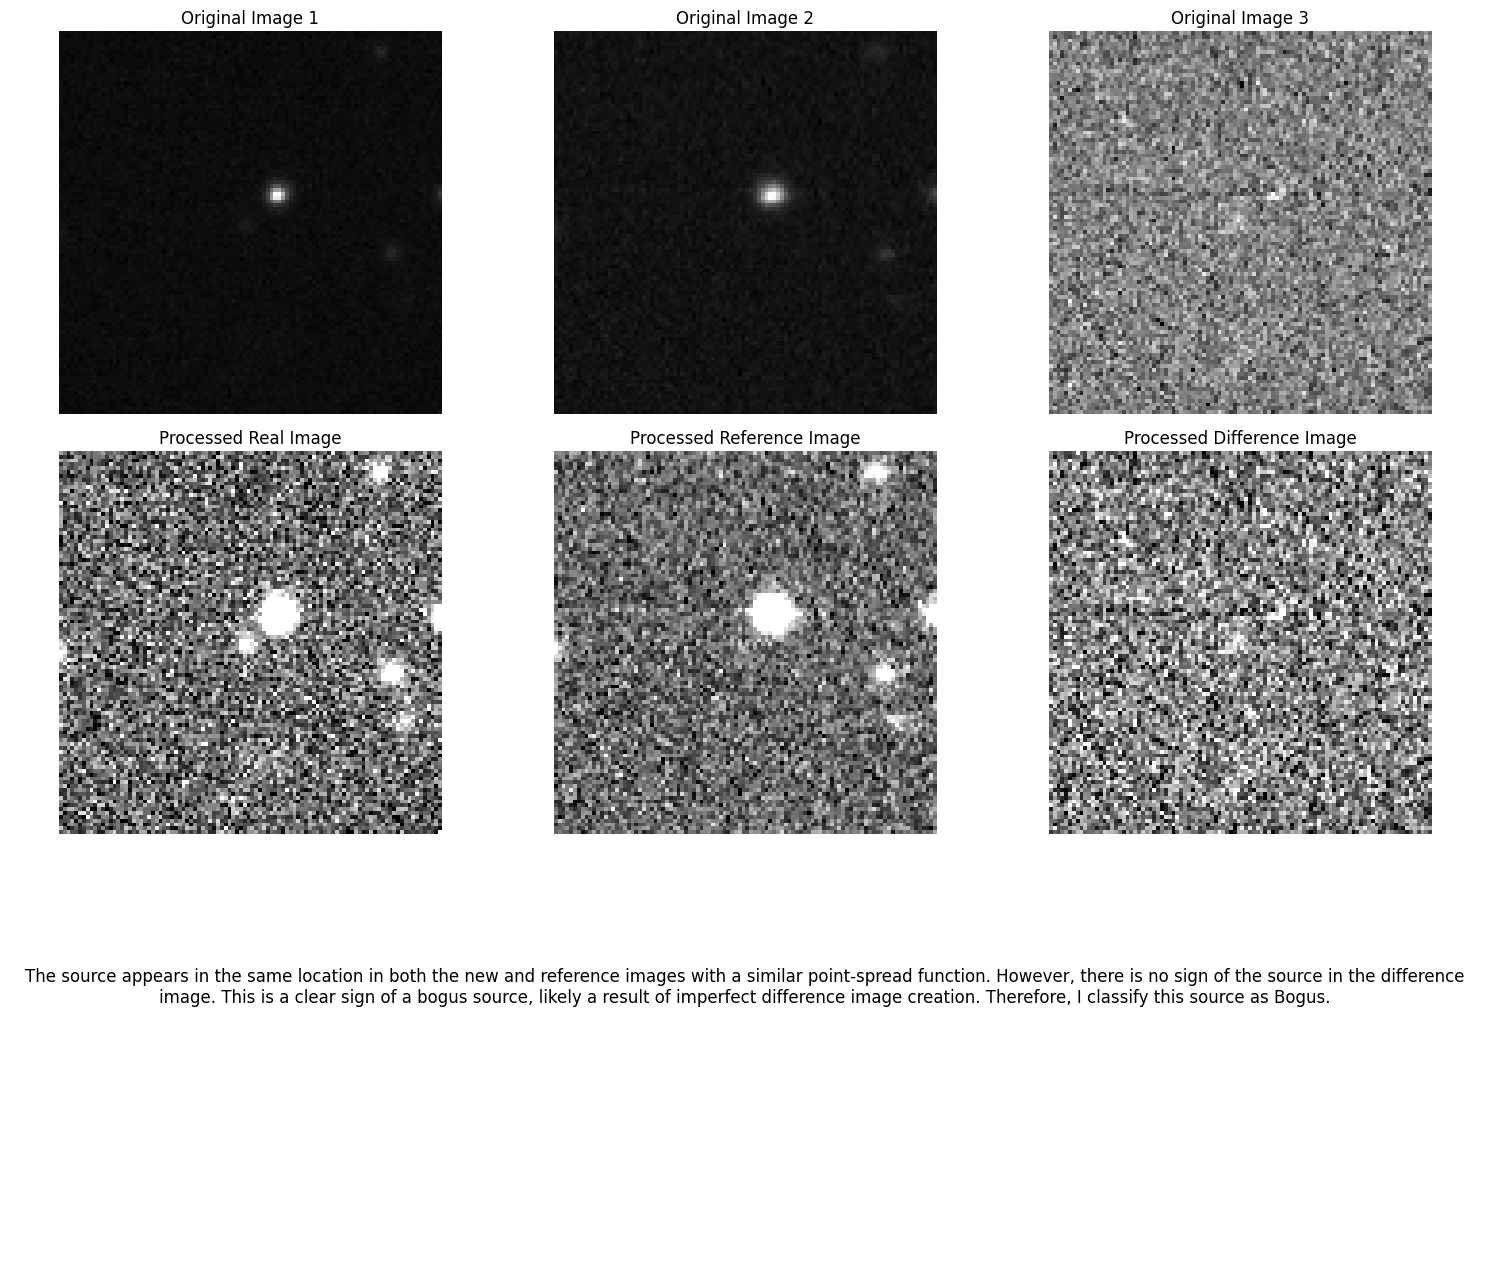

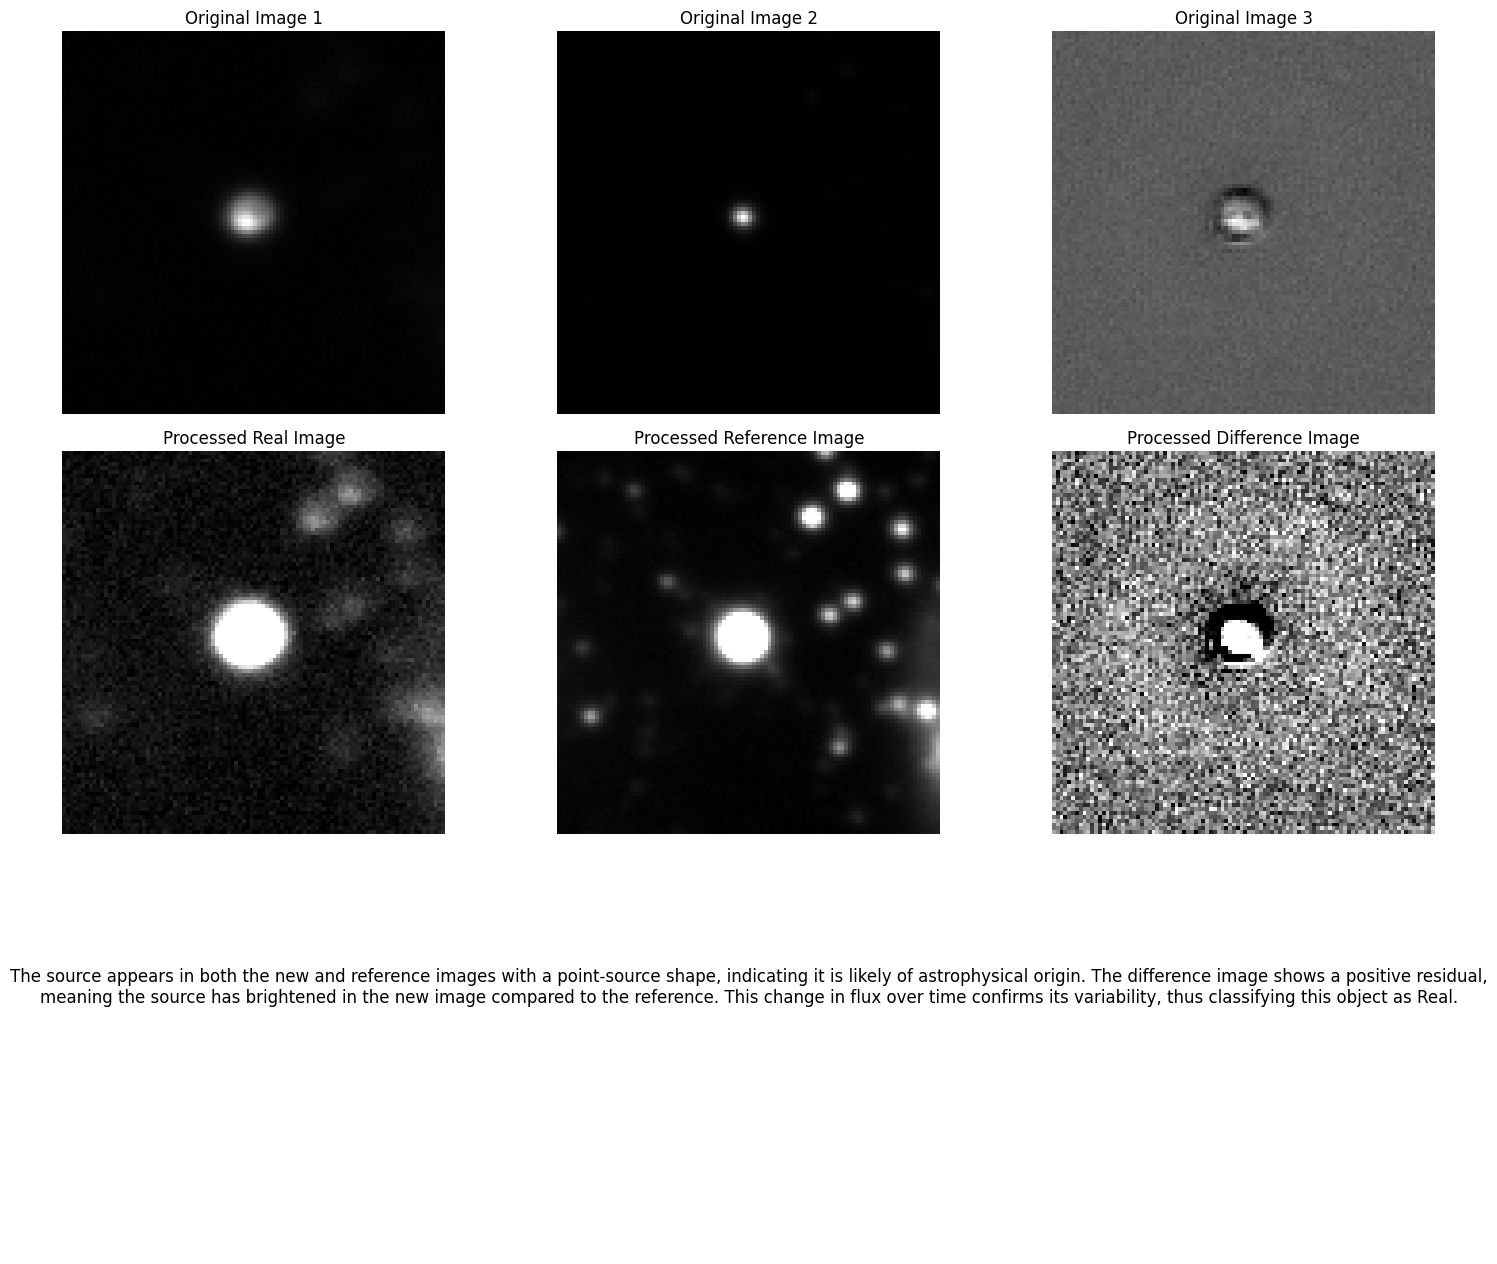

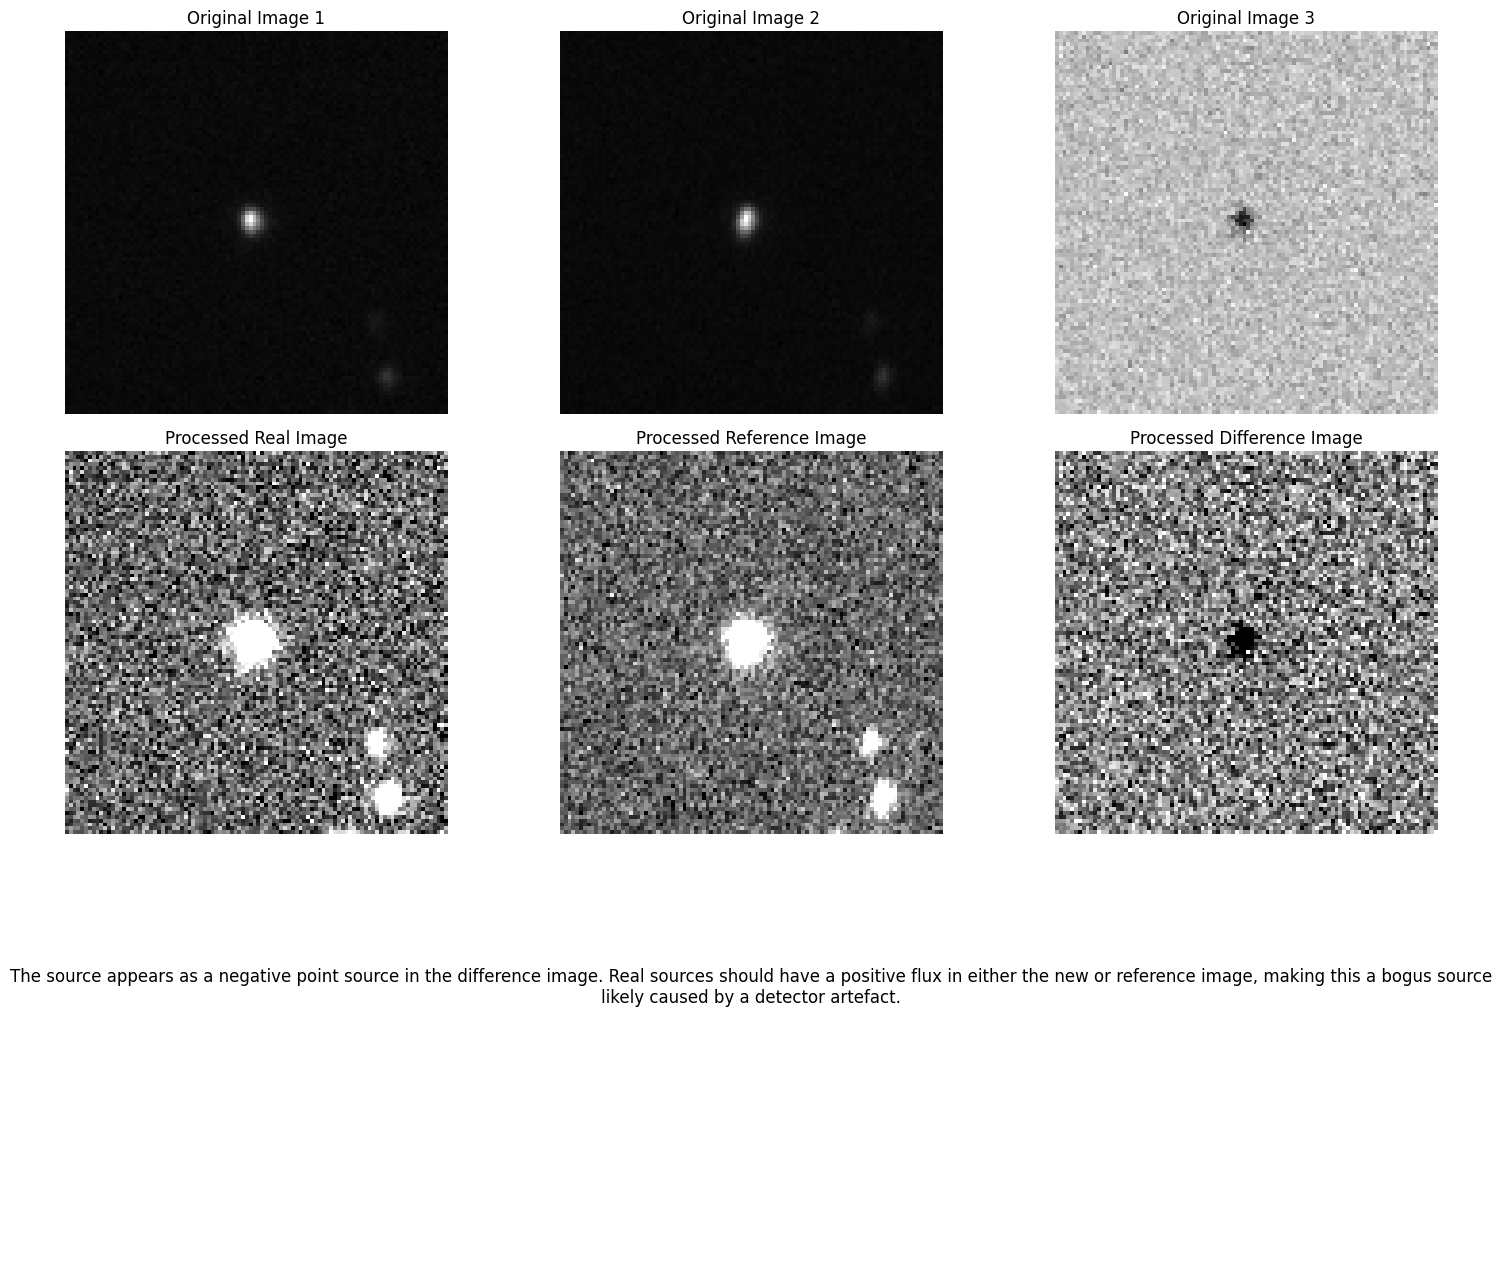

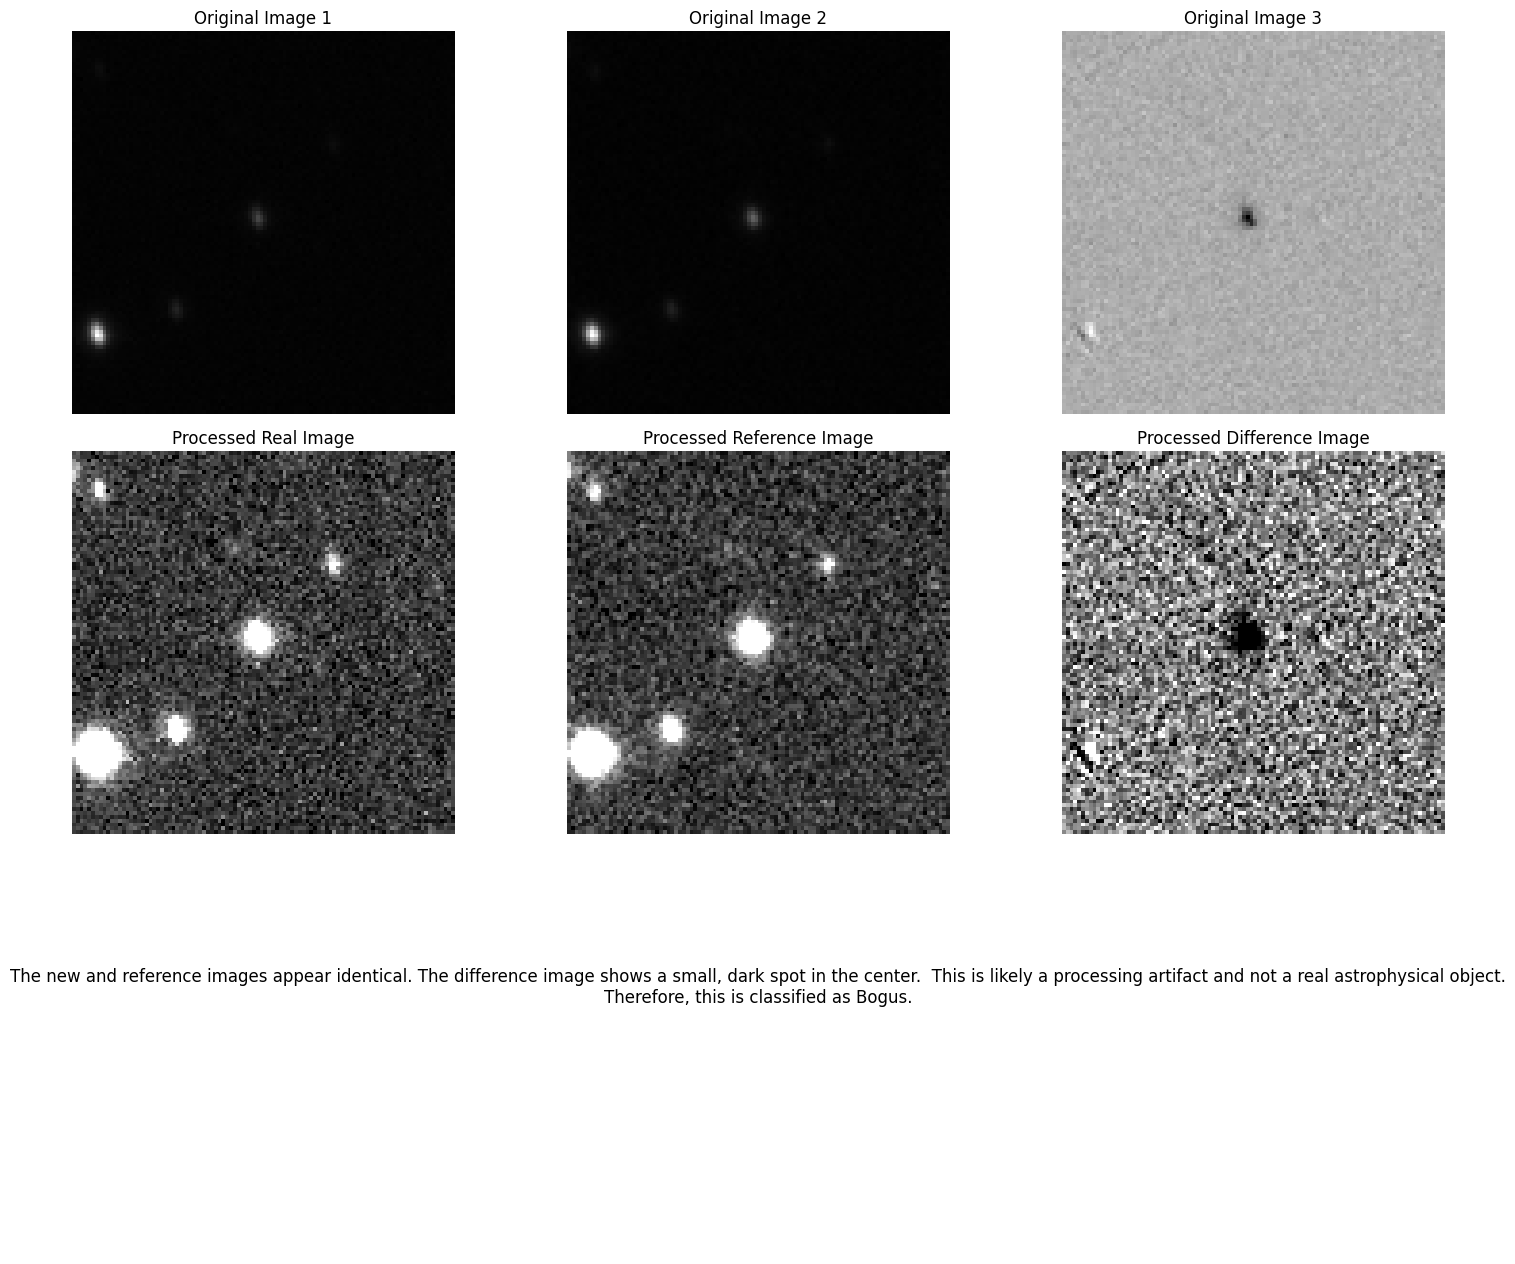

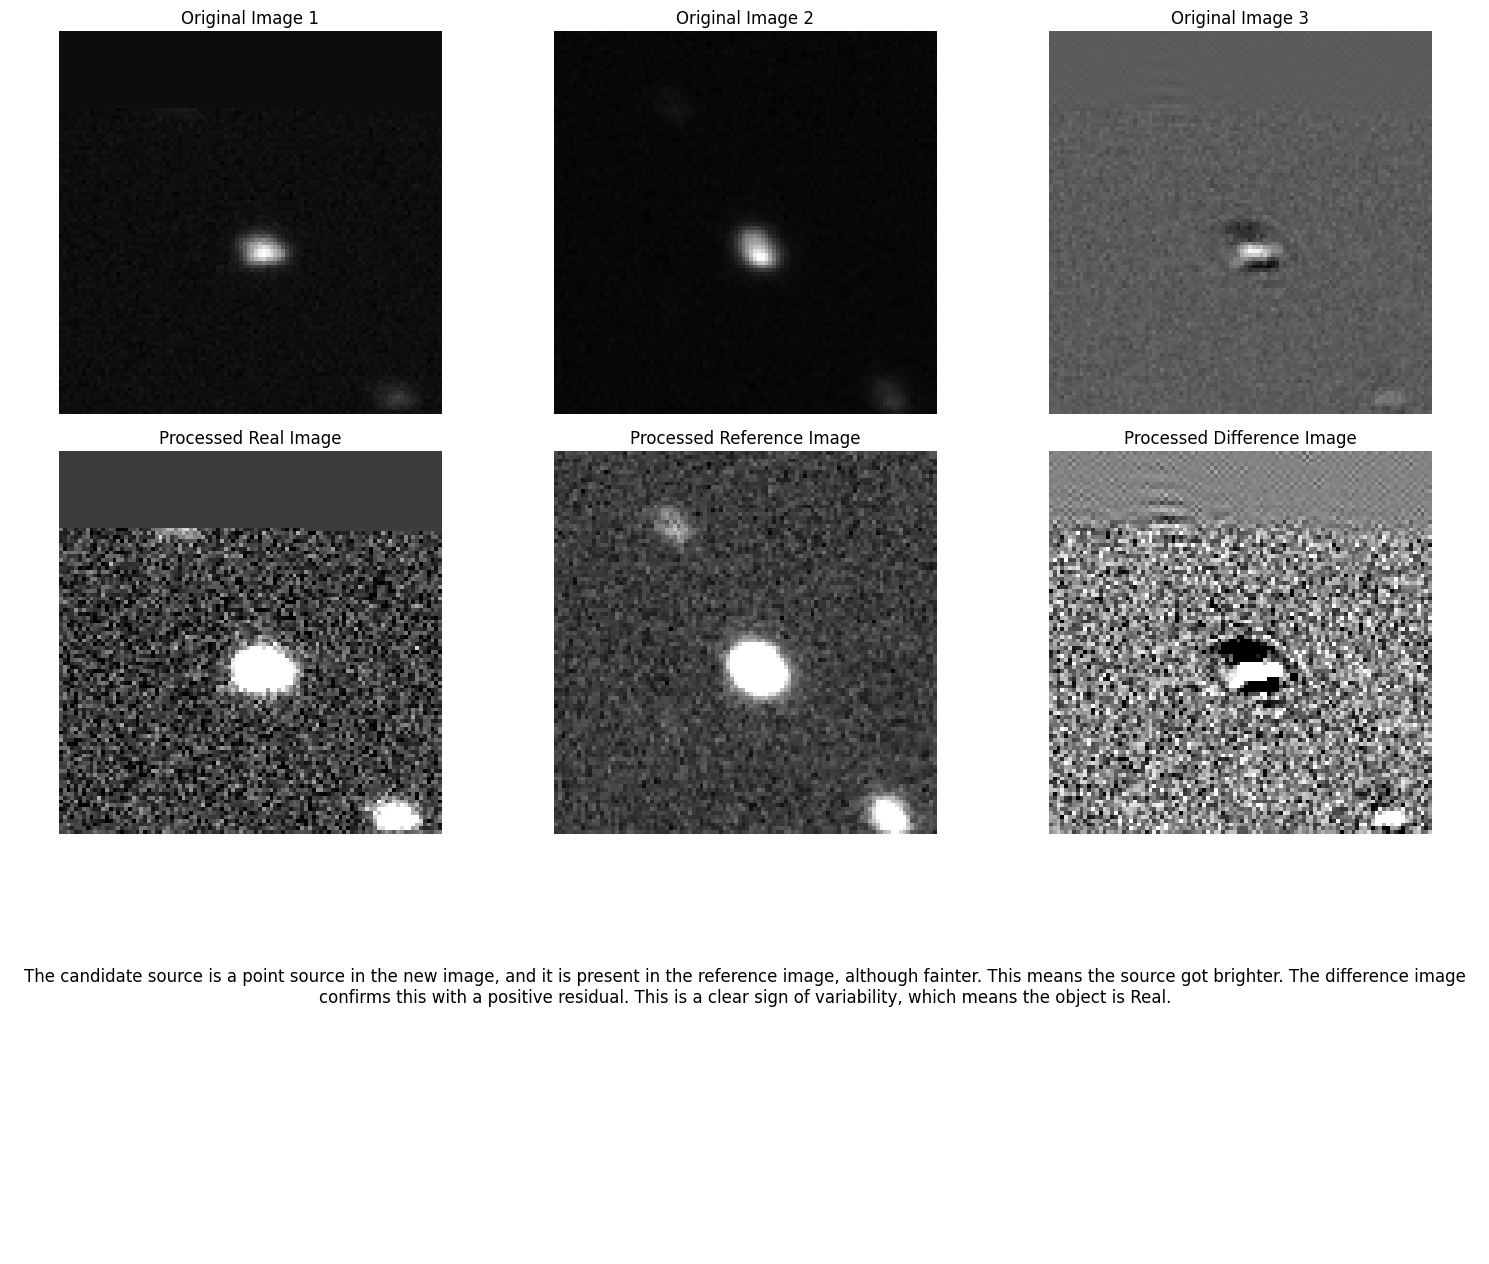

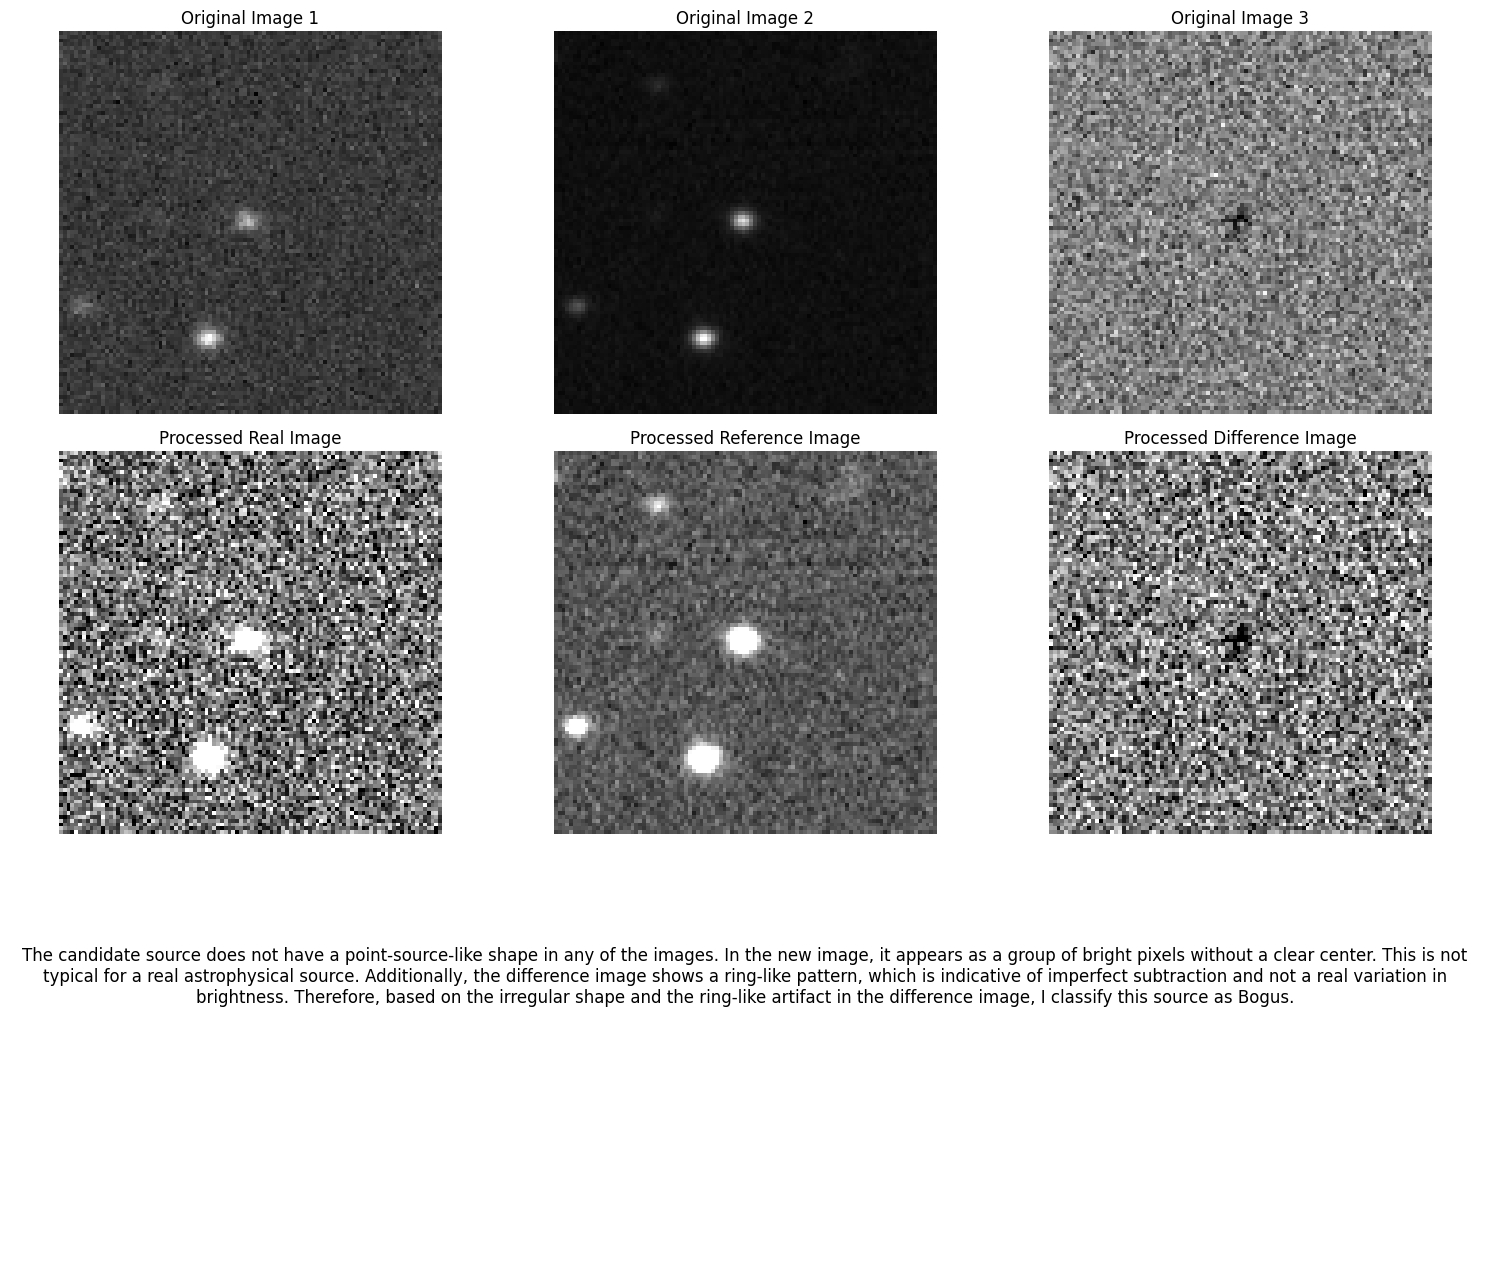

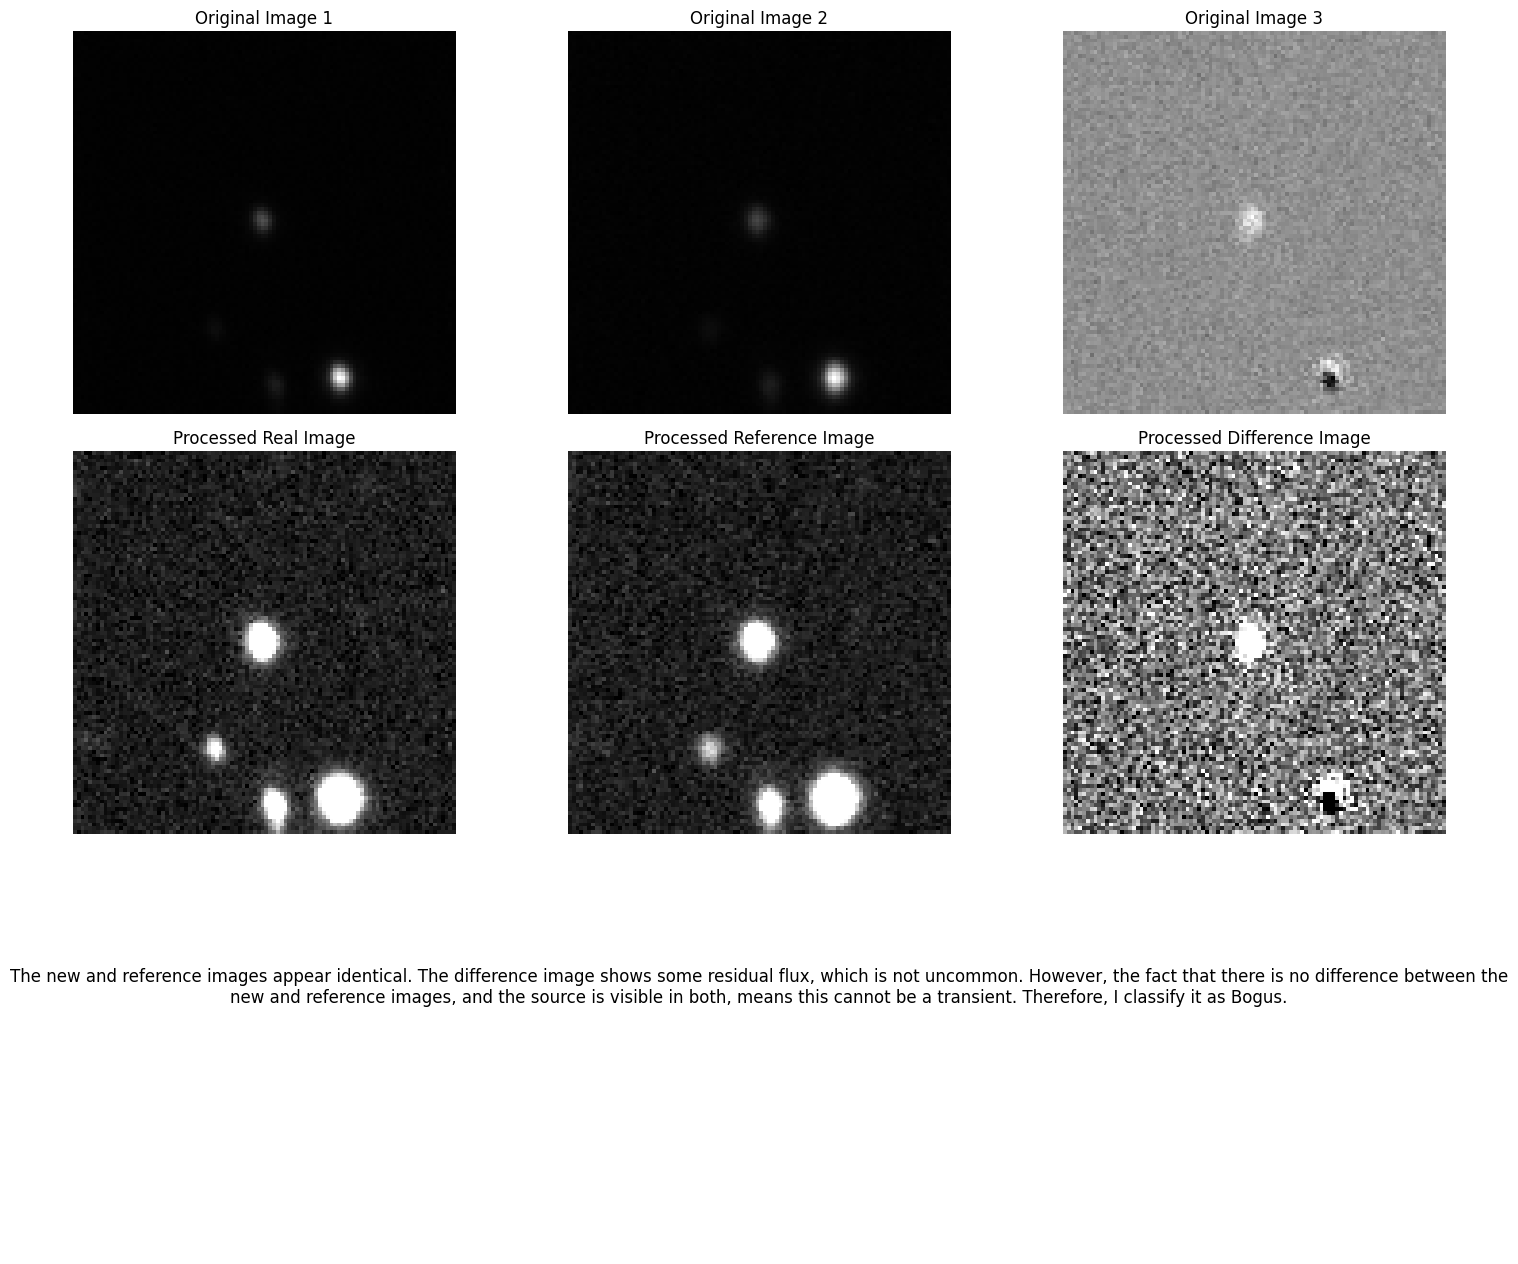

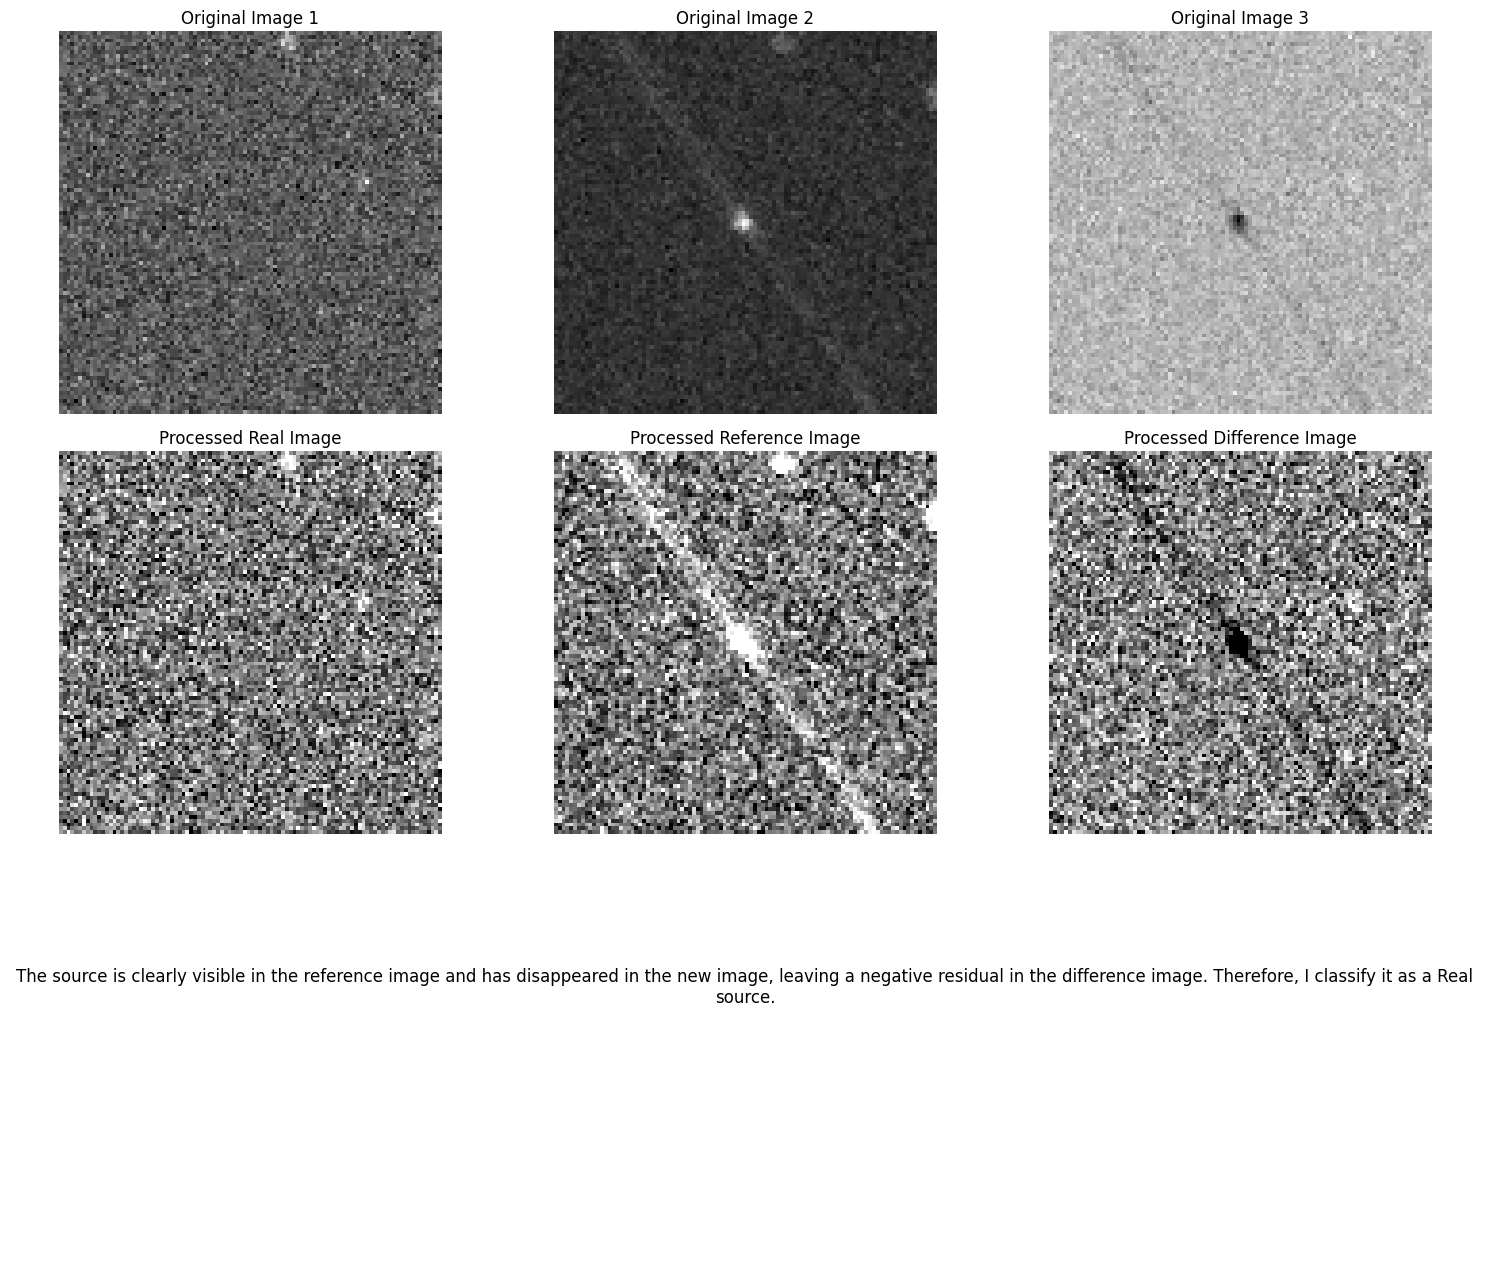

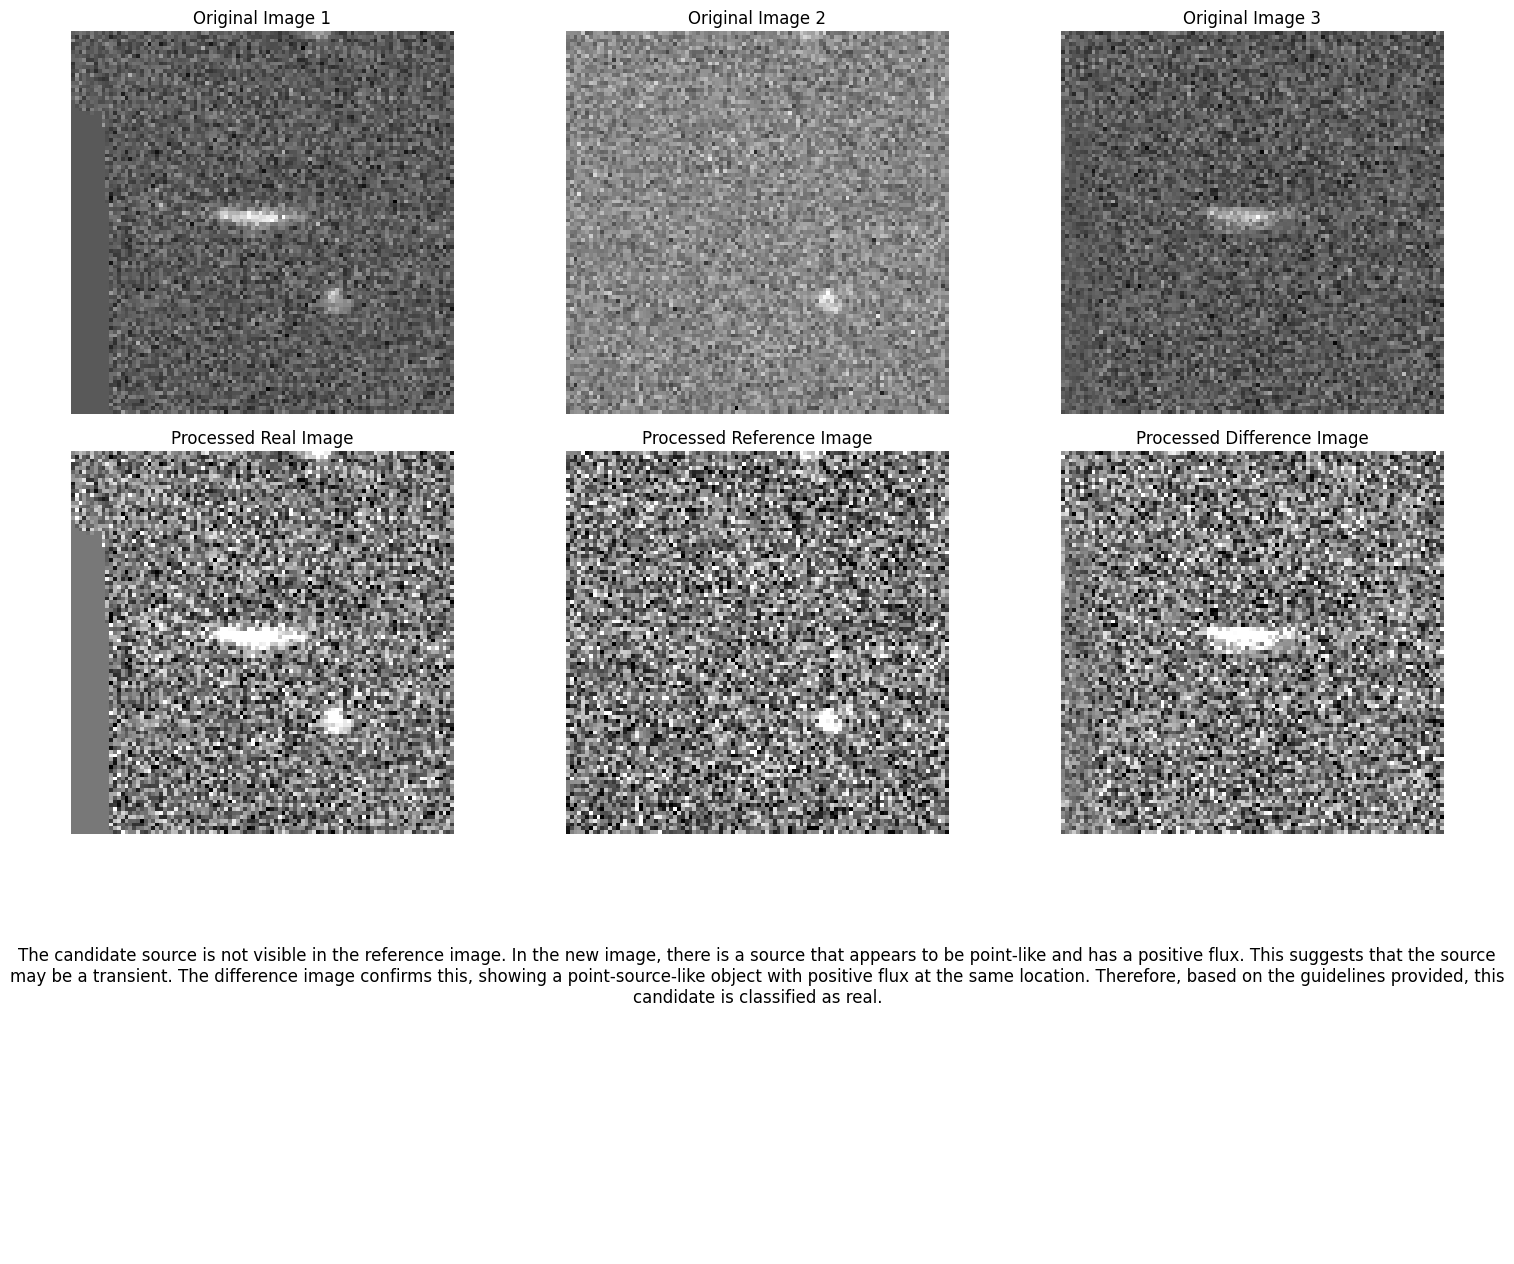

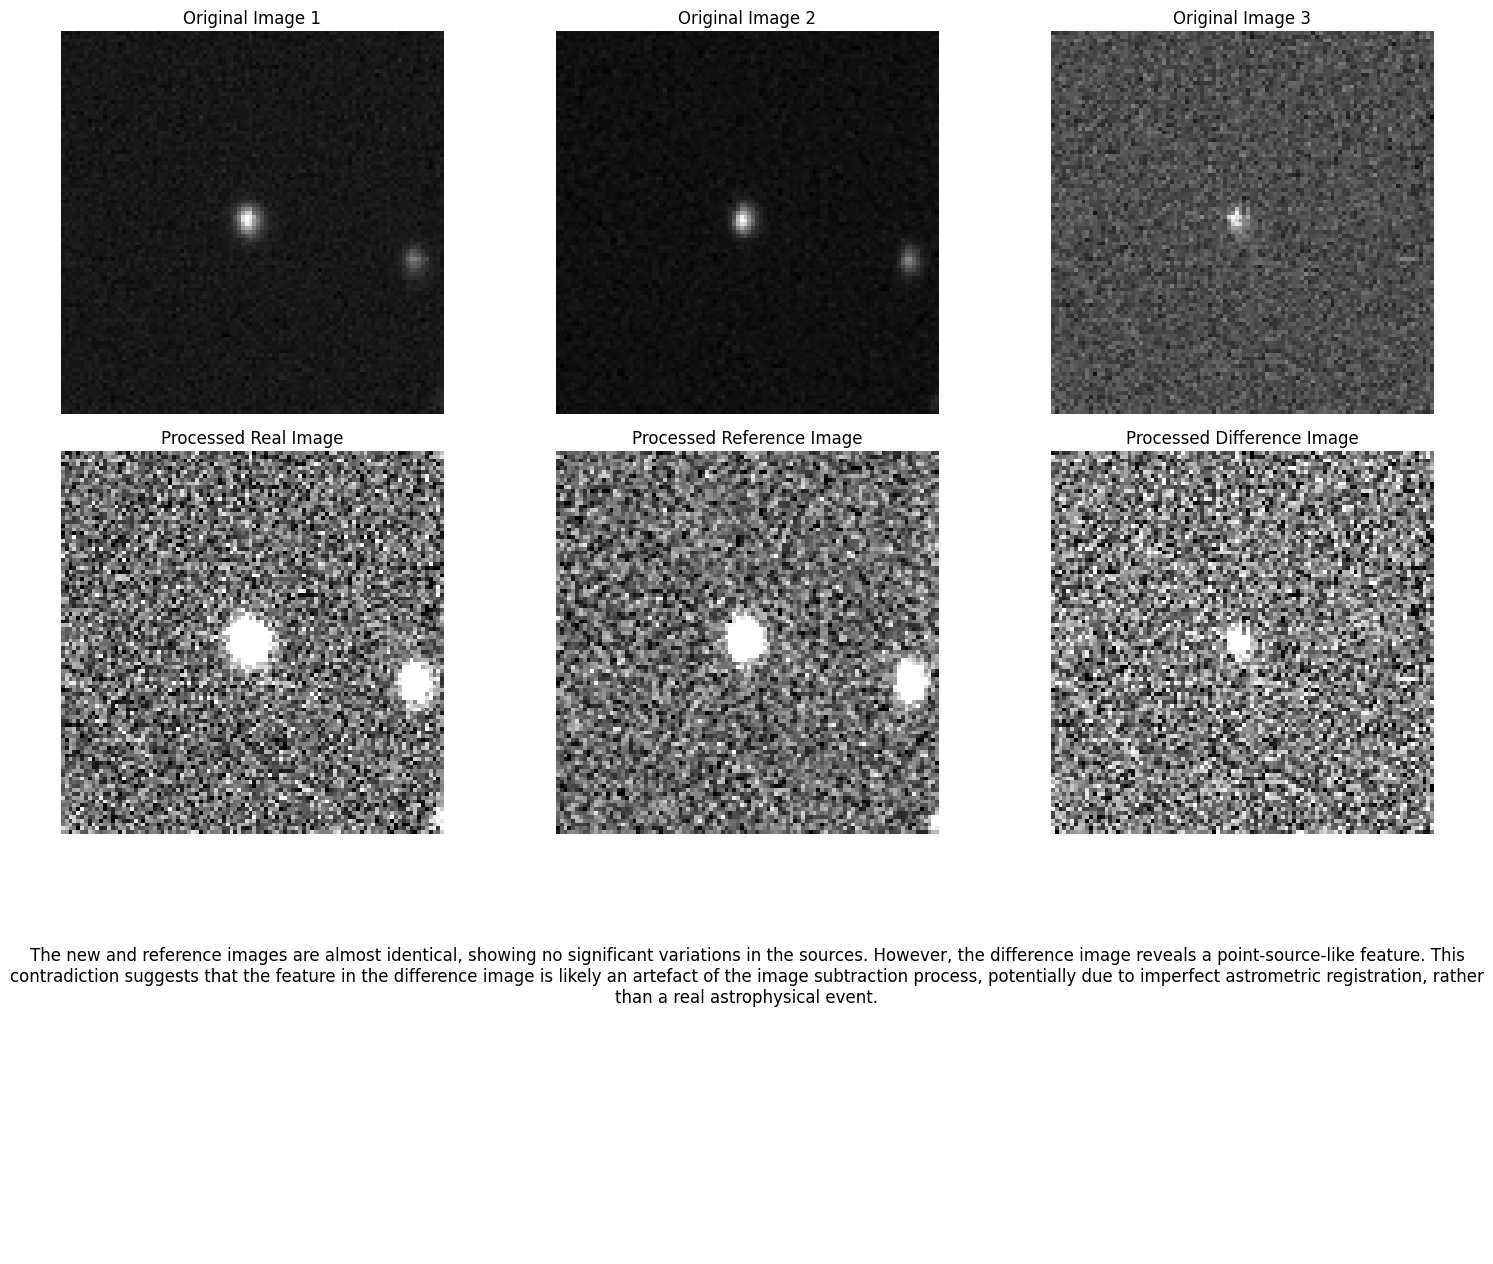

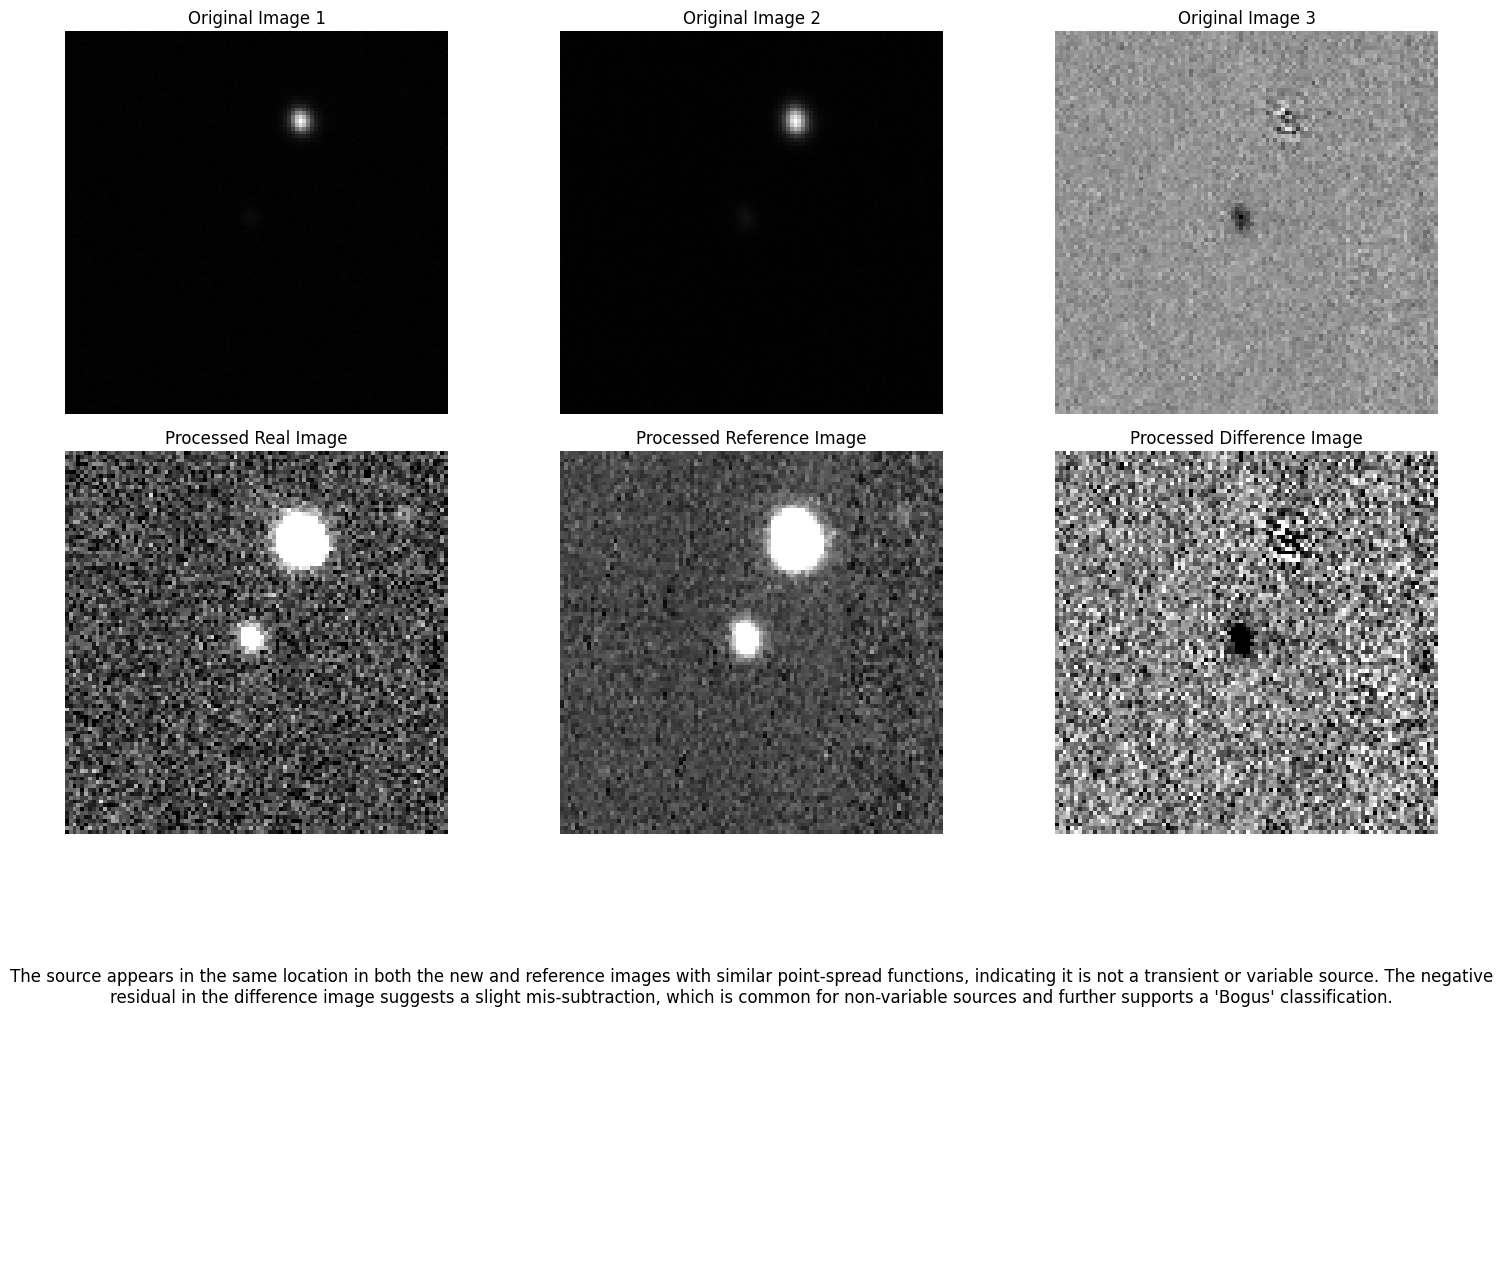

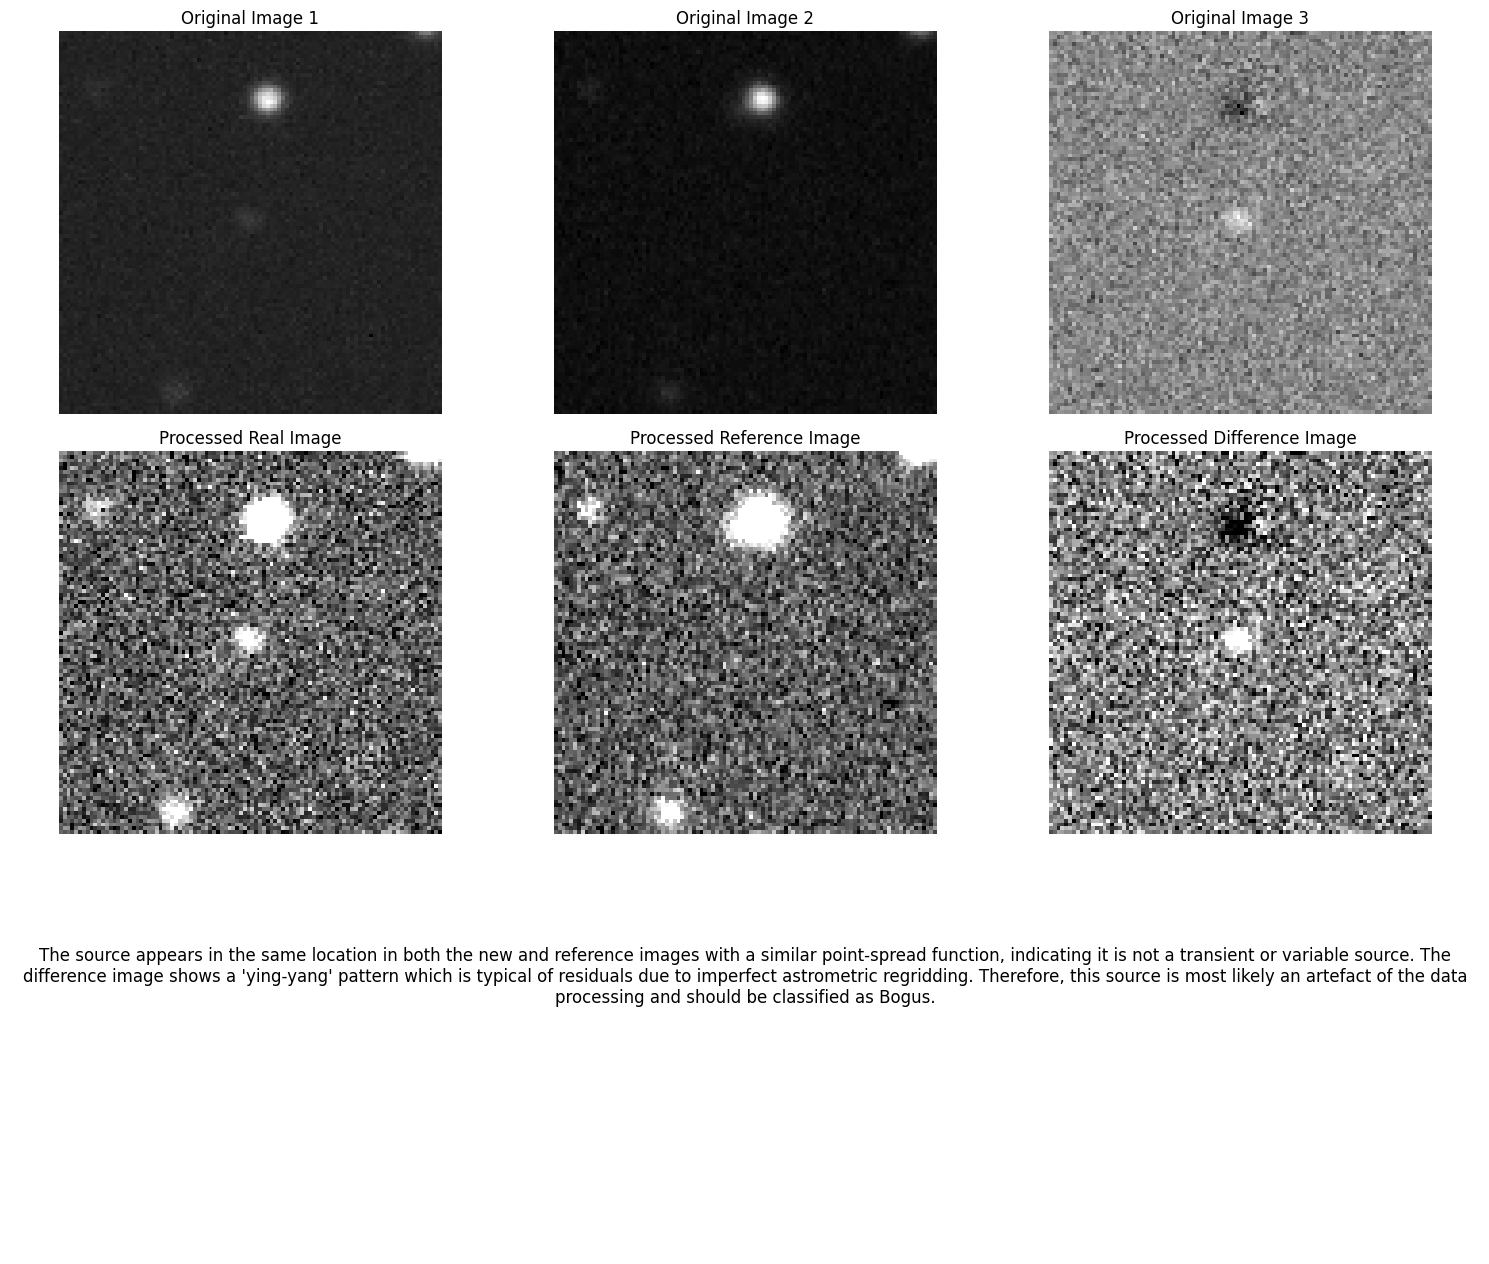

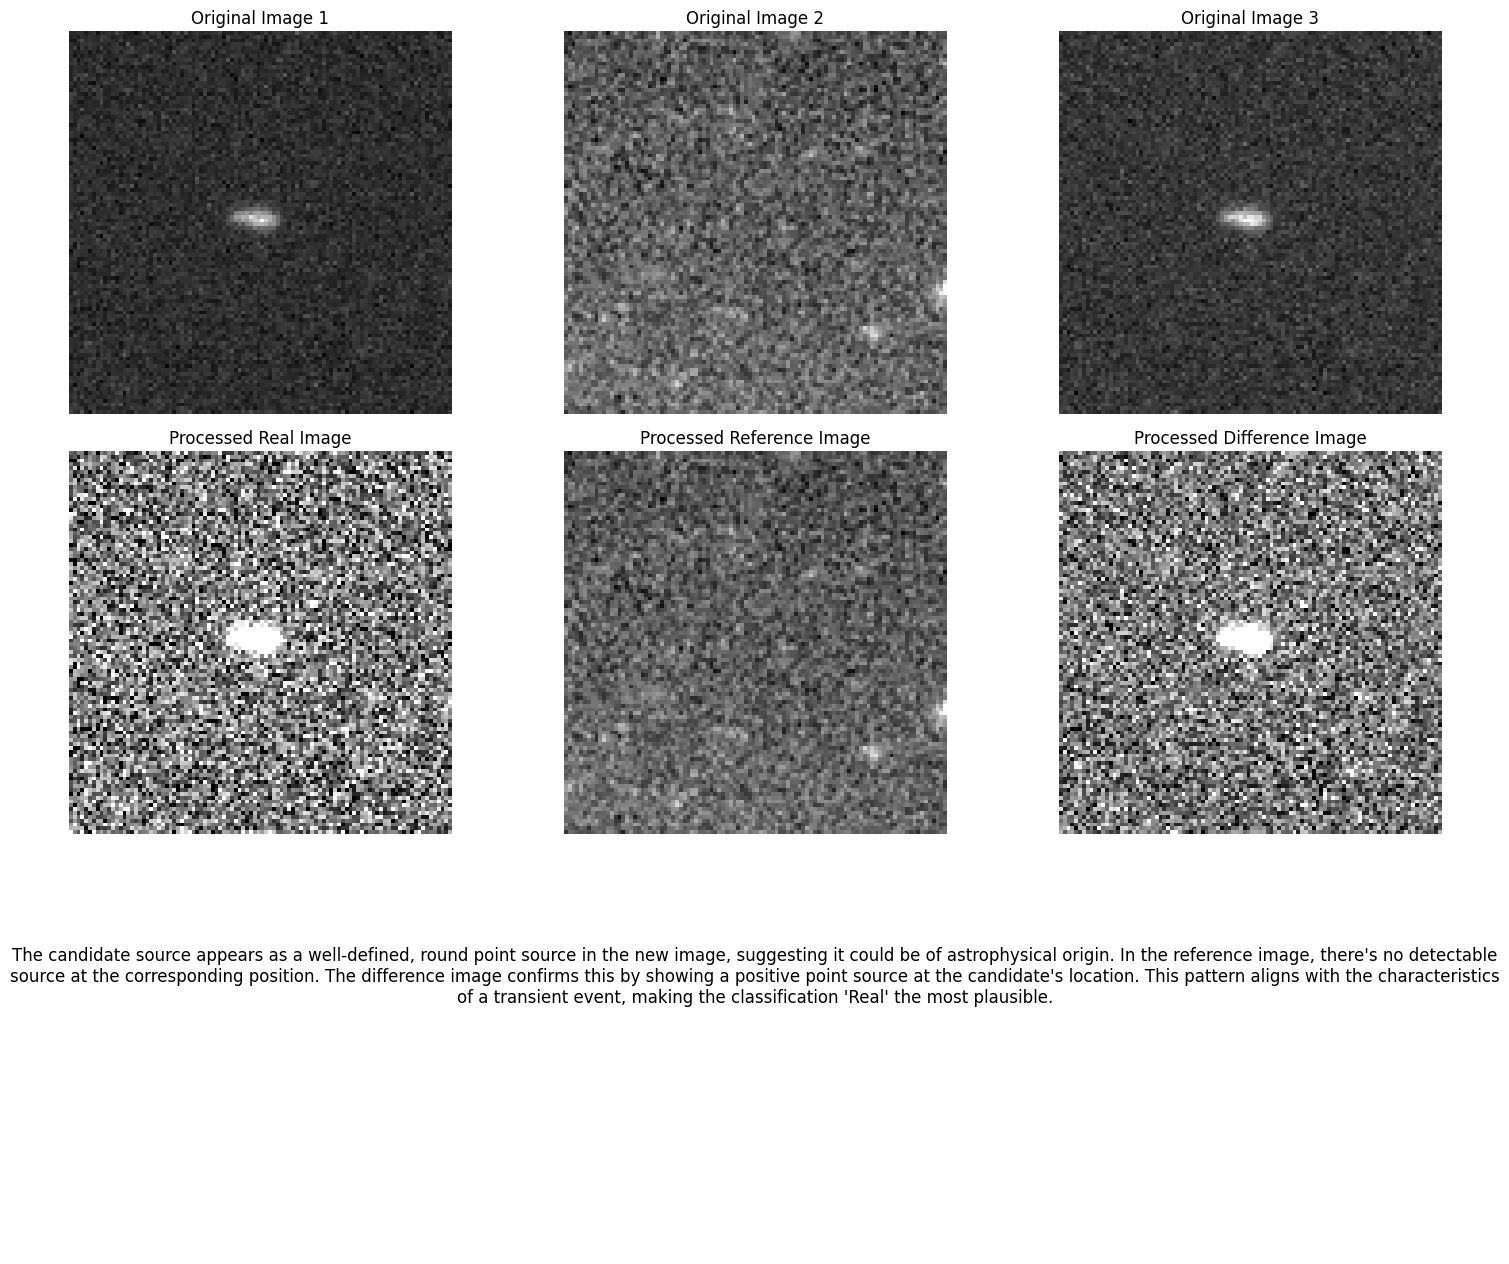

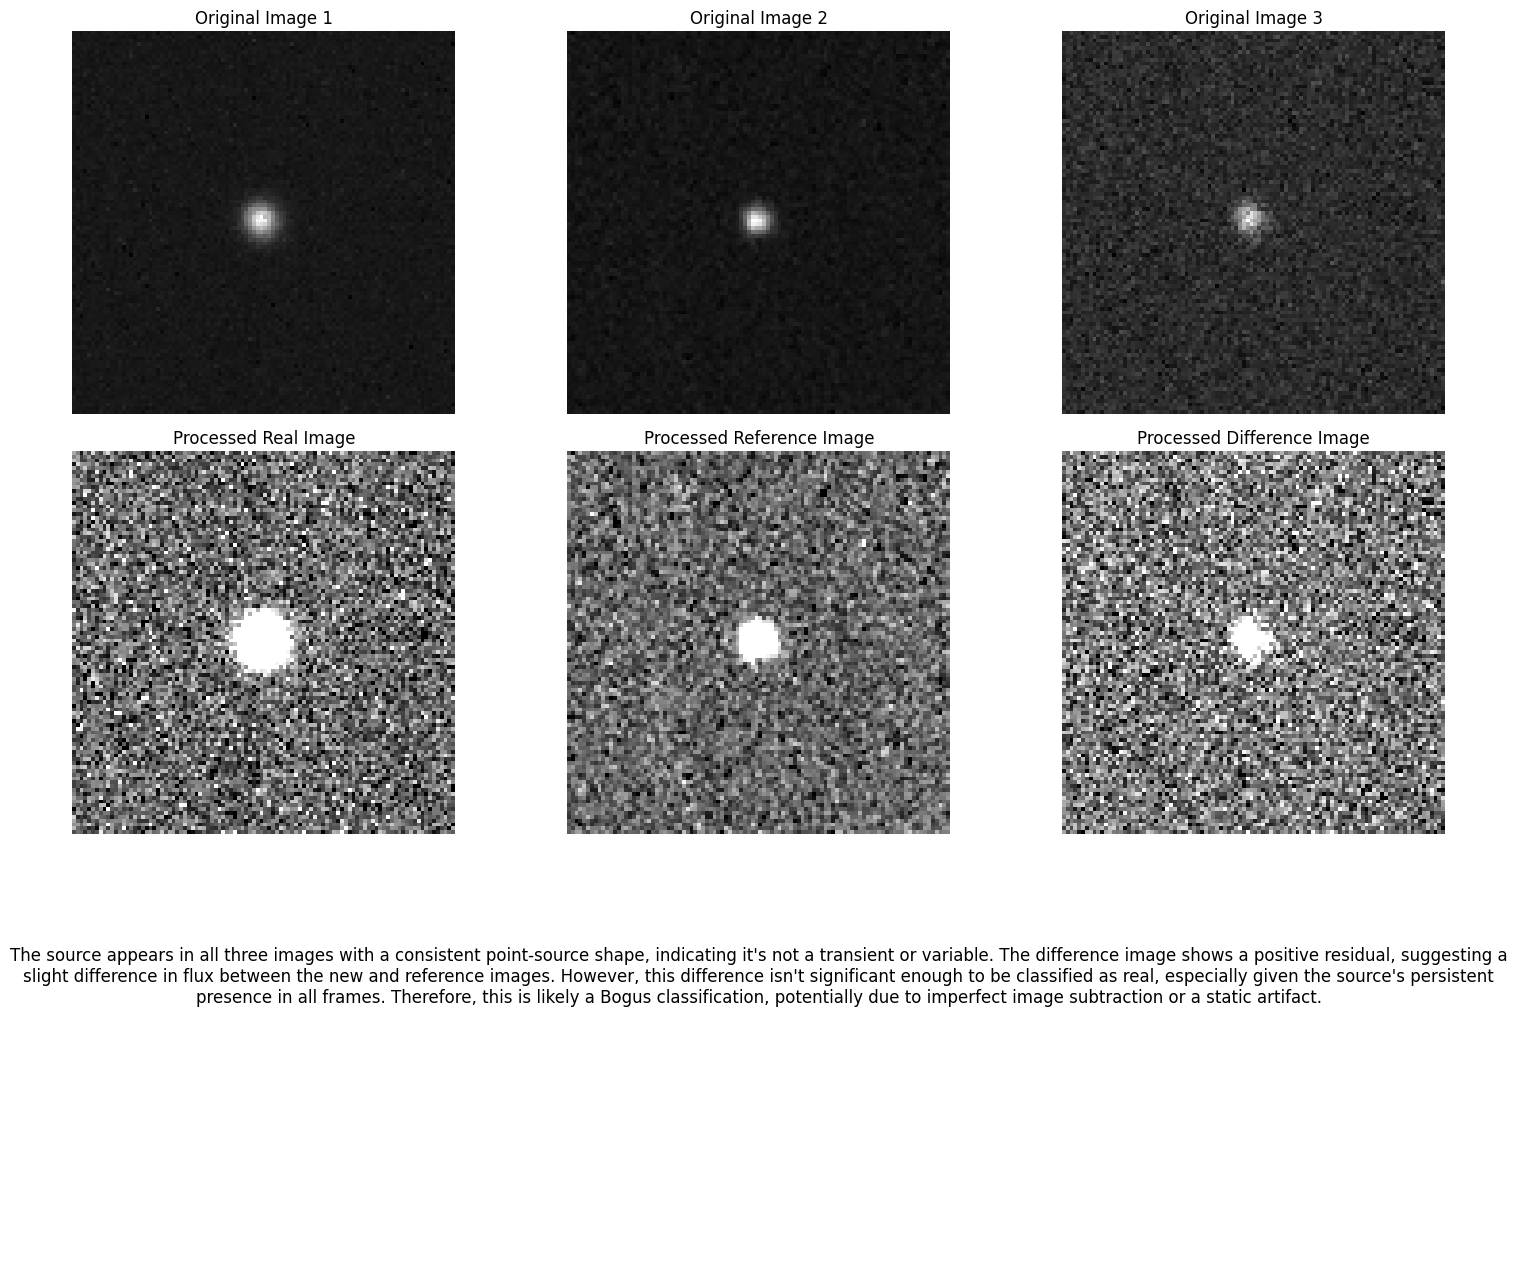

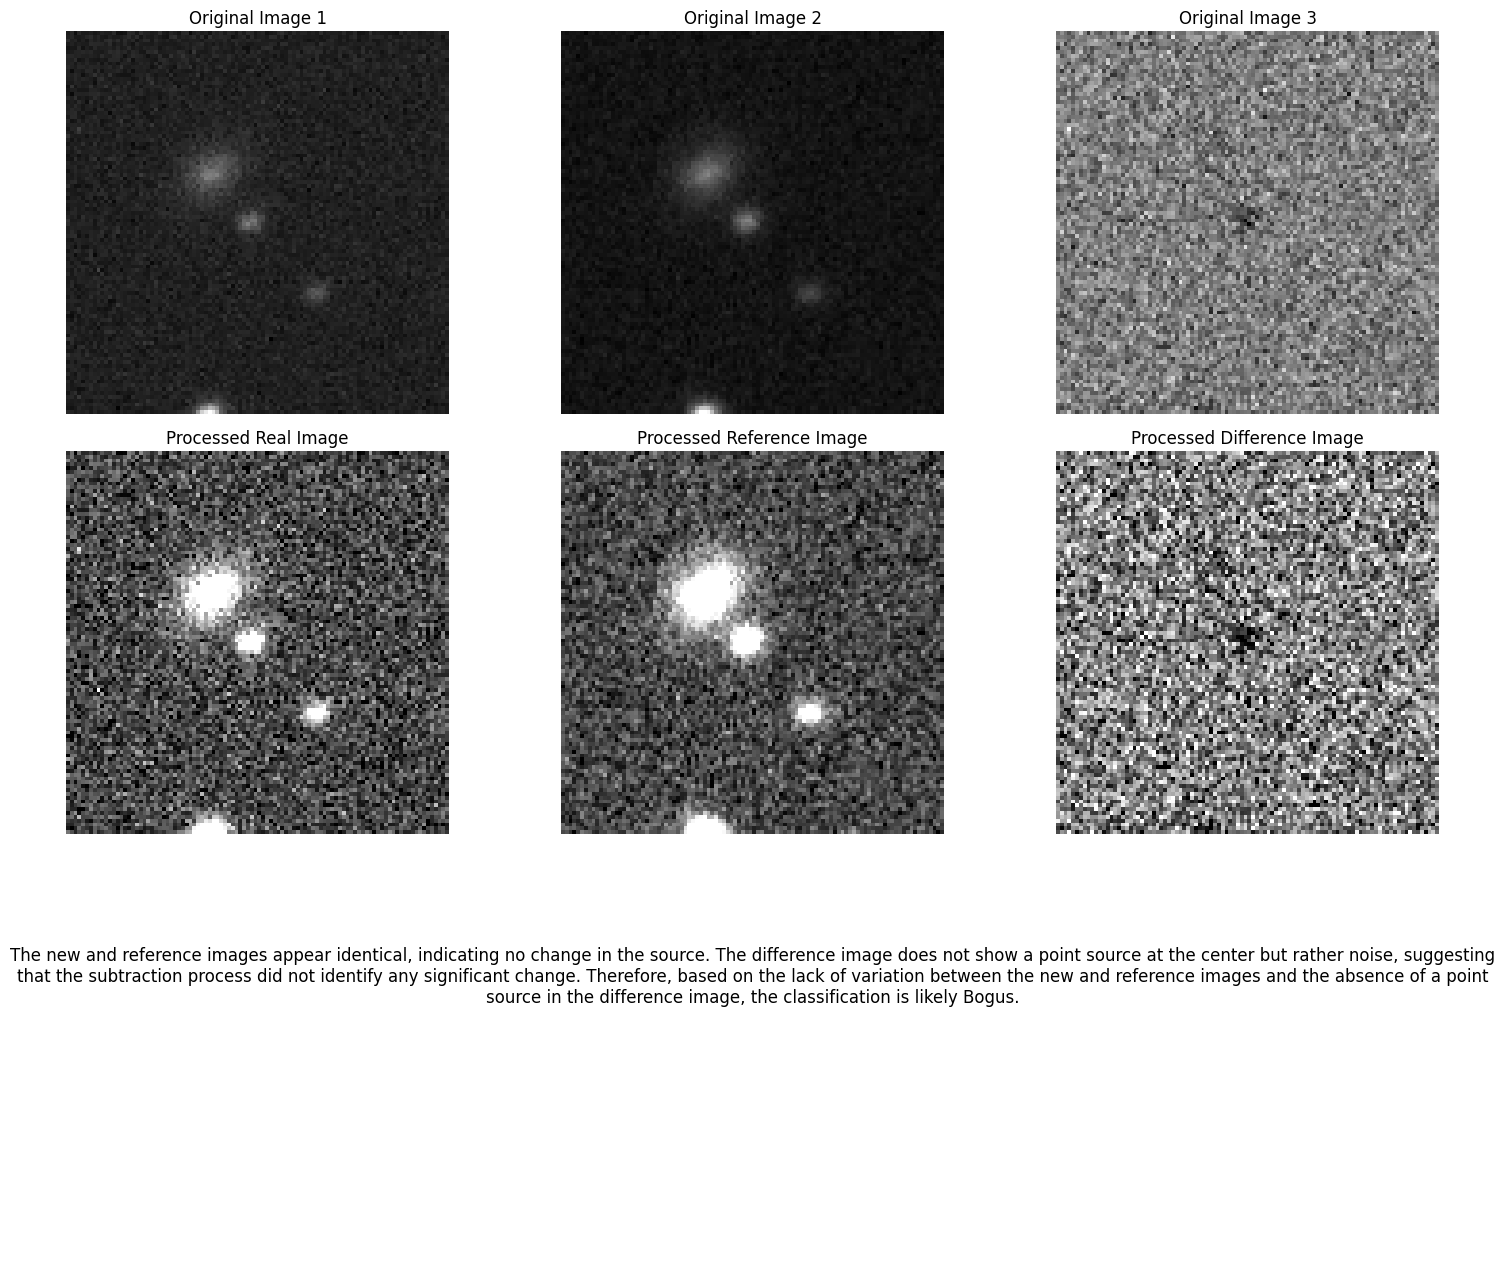

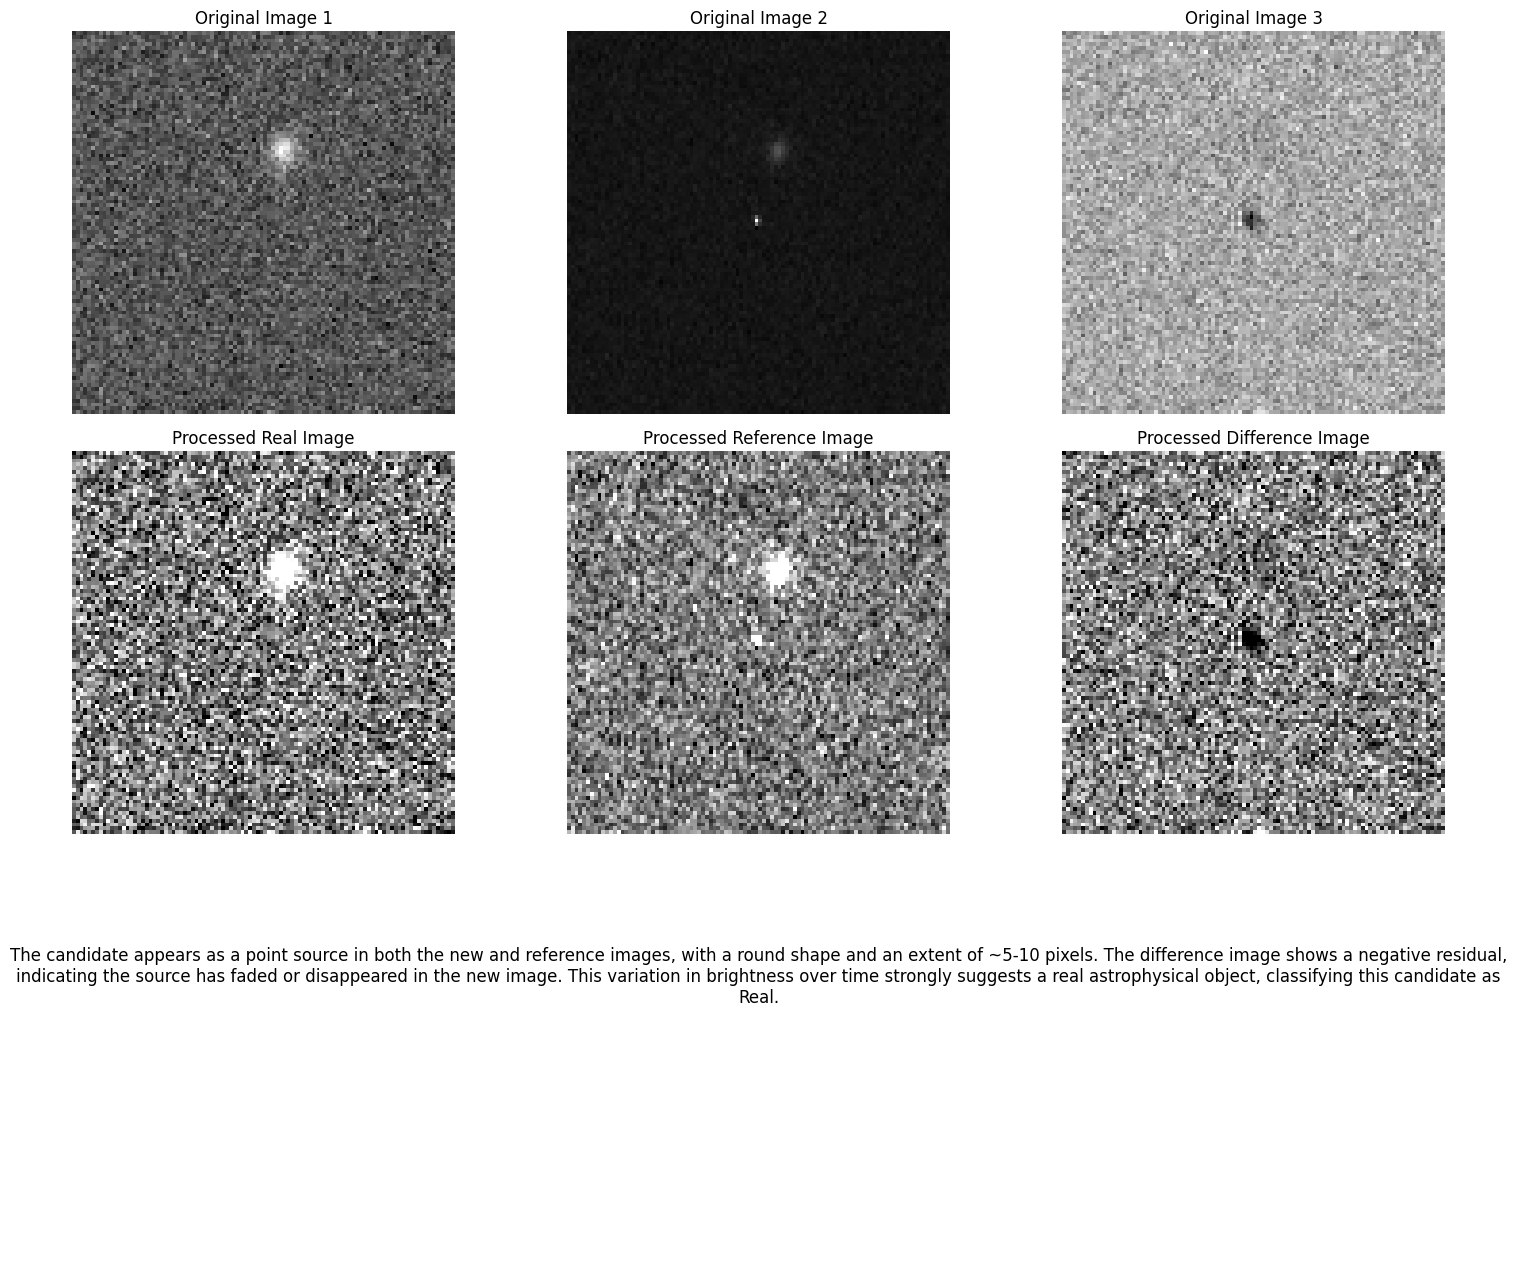

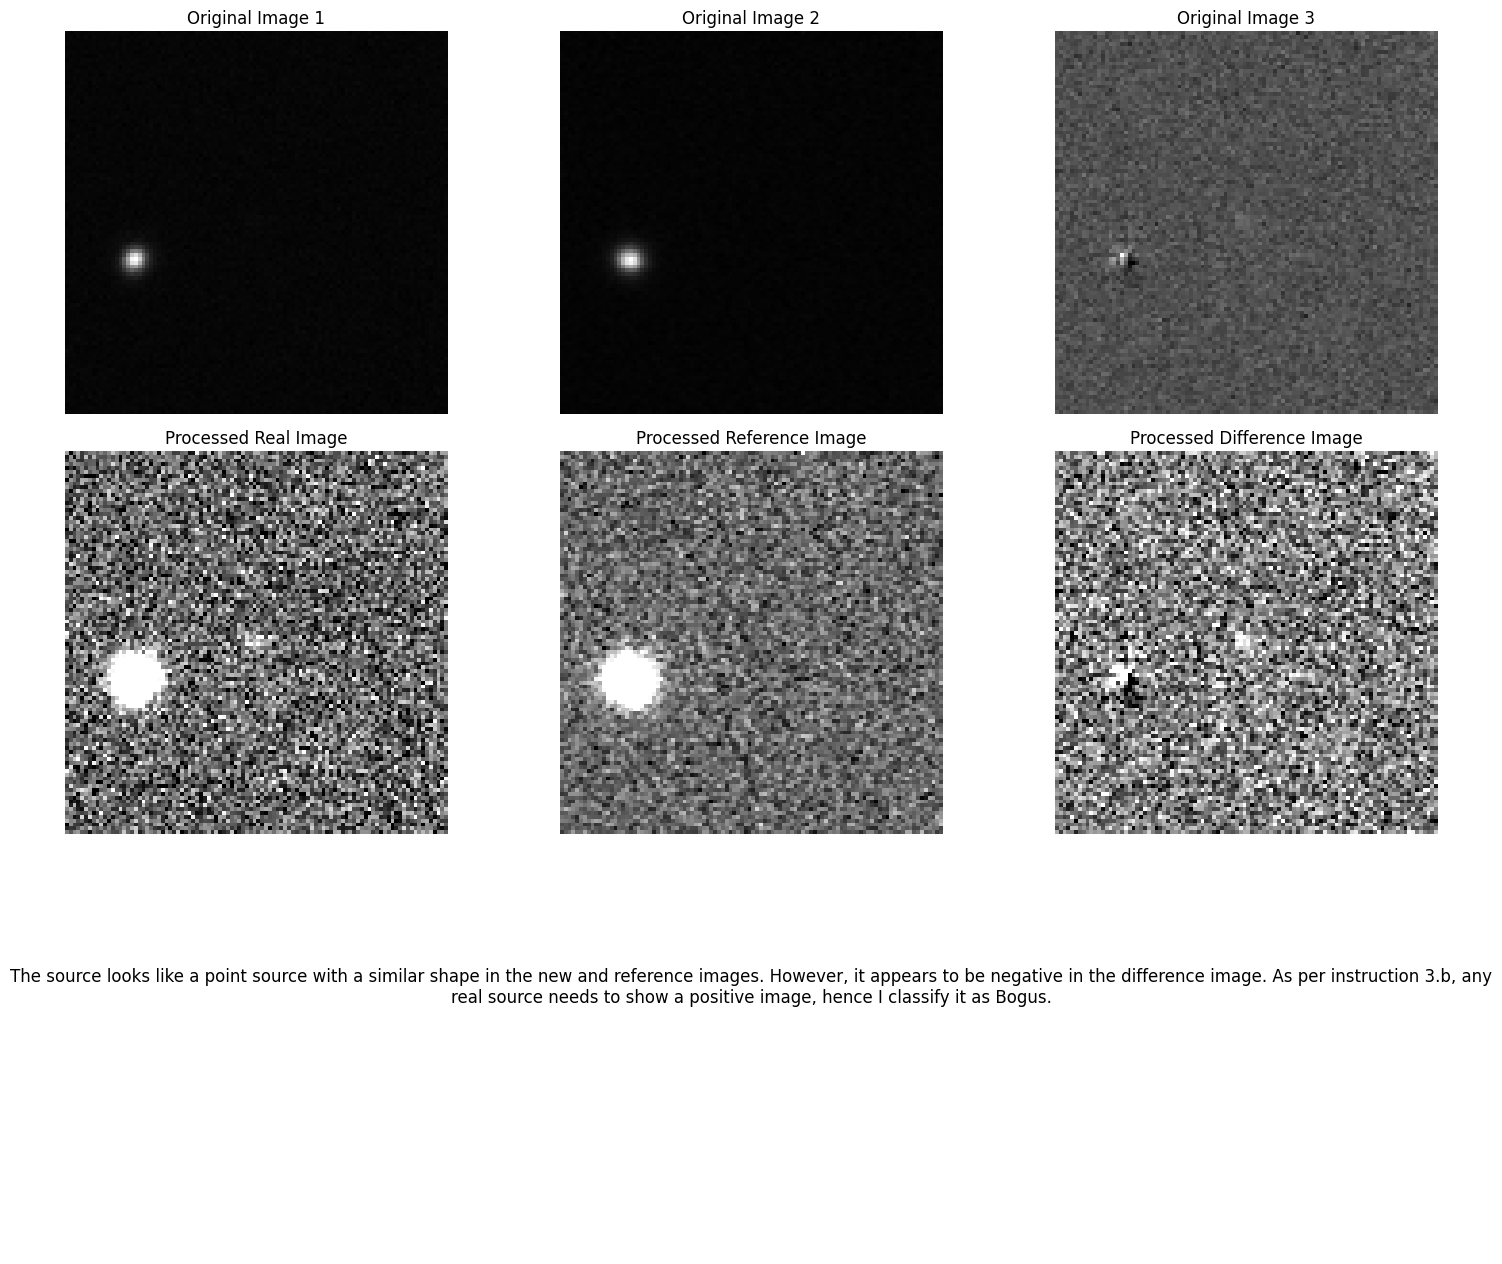

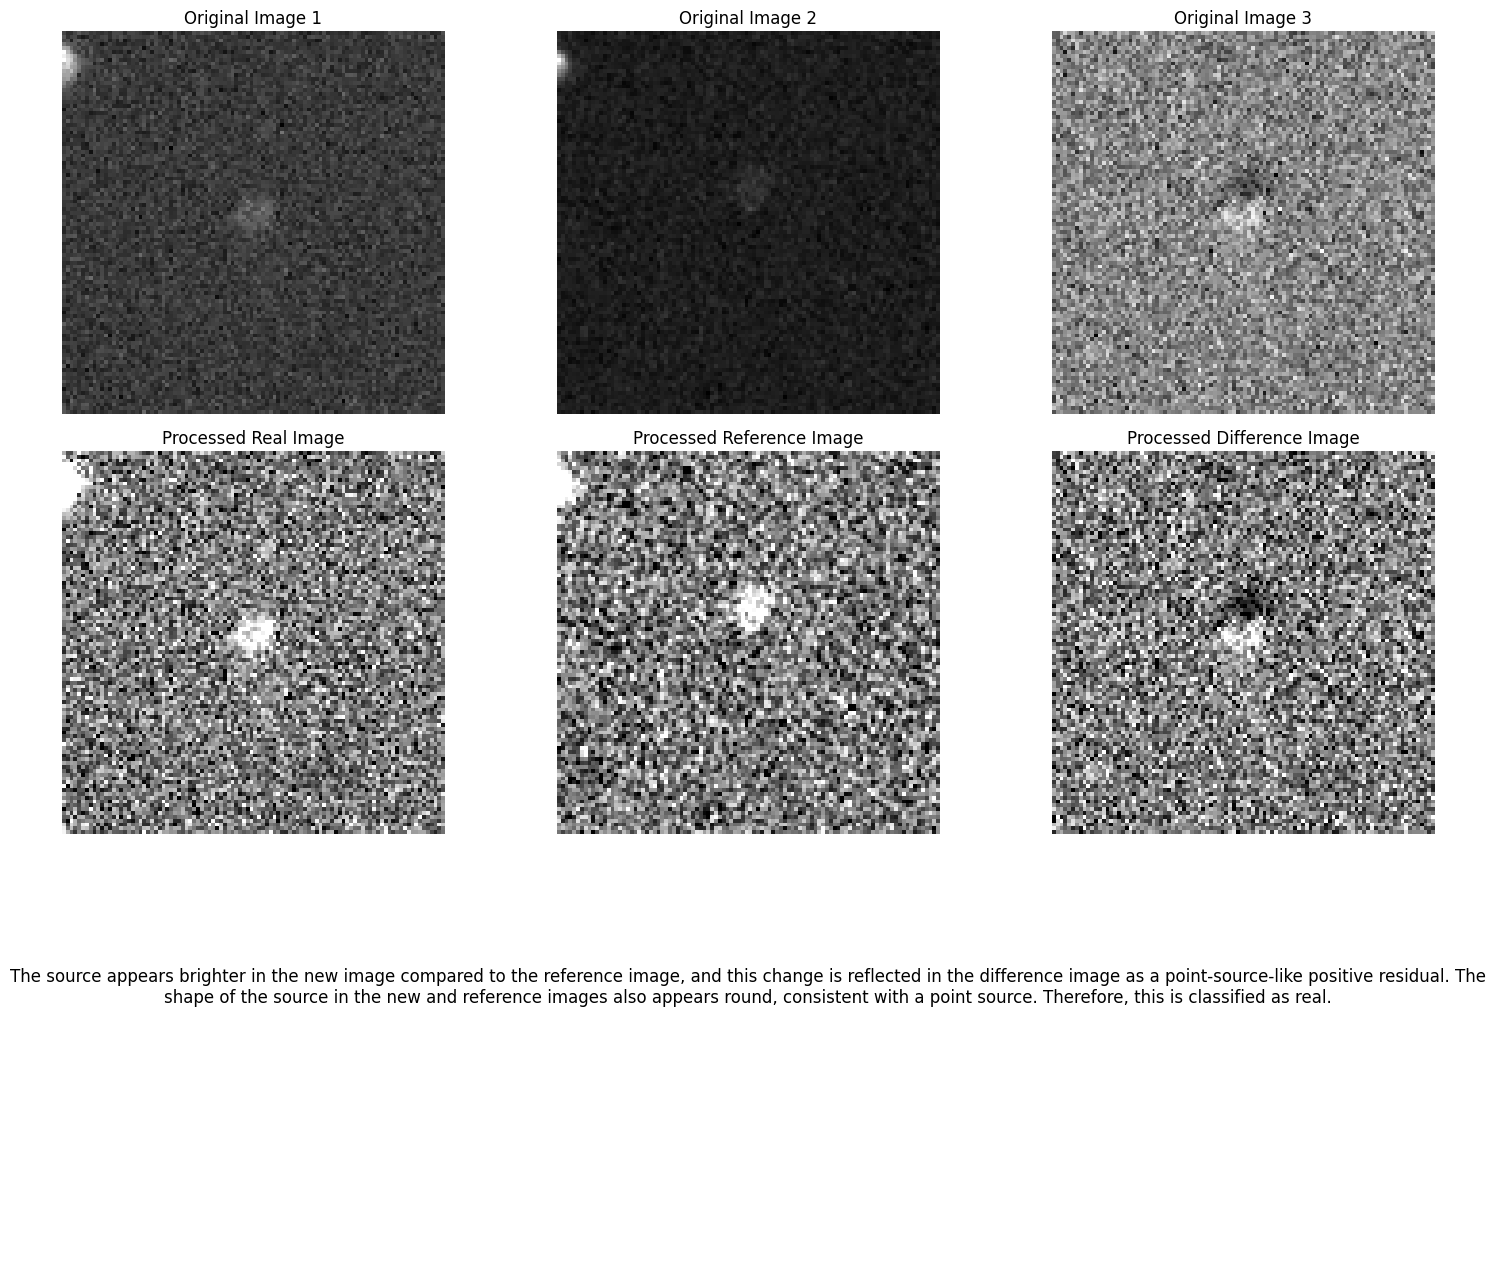

In [ ]:
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/GEMINI_PROJECT/pred2.csv'

# Load the predictions and explanations
pred_df = pd.read_csv(csv_file_path)

# Function to plot images
def plot_images(index_no, dataset, processed_images=None, explanation=None):
    """Plots the images, both original and optionally preprocessed, and displays the explanation."""
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for j in range(3):
        arr = dataset[index_no, :, :, j]
        axes[0, j].imshow(arr, cmap='gray')
        axes[0, j].axis('off')
        axes[0, j].set_title(f'Original Image {j + 1}')

    if processed_images is not None:
        titles = ['Real Image', 'Reference Image', 'Difference Image']
        for j in range(3):
            arr = processed_images[j]
            axes[1, j].imshow(arr, cmap='gray')
            axes[1, j].axis('off')
            axes[1, j].set_title(f'Processed {titles[j]}')

    # Add an empty plot for spacing
    for ax in axes[2]:
        ax.axis('off')

    if explanation is not None:
        #fig.suptitle('Explanation', fontsize=16)
        fig.text(0.5, 0.28, explanation, wrap=True, horizontalalignment='center', fontsize=12)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()


# Identify mismatches and plot images with explanations
mismatched_indices = pred_df[pred_df['label'] != pred_df['prediction']]['index'].values

for i in mismatched_indices:
    real_image, ref_image, norm_diff_image, label = preprocess(quadruplets, labels_df['label'].values, i)
    processed_images = [real_image, ref_image, norm_diff_image]
    explanation = pred_df[pred_df['index'] == i]['explanation'].values[0]
    plot_images(i, quadruplets, processed_images, explanation)